In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

pd.set_option('display.max_columns', None)

%load_ext rpy2.ipython

In [2]:
%%R
library(GSA)
library(msigdbr)
library(fgsea)
library(tidyverse) # includes ggplot2, for data visualisation. dplyr, for data manipulation.
library(RColorBrewer) # for a colourful plot

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R

set.seed(42)

# Figure out how to set up gene lists

In [4]:
%%R

all_gene_sets = msigdbr(species = "Mus musculus")
head(all_gene_sets)

# A tibble: 6 × 18
  gs_cat gs_subcat      gs_name        gene_symbol entrez_gene ensembl_gene     
  <chr>  <chr>          <chr>          <chr>             <int> <chr>            
1 C3     MIR:MIR_Legacy AAACCAC_MIR140 Abcc4            239273 ENSMUSG000000328…
2 C3     MIR:MIR_Legacy AAACCAC_MIR140 Abraxas2         109359 ENSMUSG000000309…
3 C3     MIR:MIR_Legacy AAACCAC_MIR140 Actn4             60595 ENSMUSG000000548…
4 C3     MIR:MIR_Legacy AAACCAC_MIR140 Acvr1             11477 ENSMUSG000000268…
5 C3     MIR:MIR_Legacy AAACCAC_MIR140 Adam9             11502 ENSMUSG000000315…
6 C3     MIR:MIR_Legacy AAACCAC_MIR140 Adamts5           23794 ENSMUSG000000228…
# ℹ 12 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>, taxon_id <int>,
#   ortholog_sources <chr>, num_ortholog_sources <dbl>


In [5]:
%%R

# Get the MSigDB collections
collections <- msigdbr_collections()

# Print all rows of the tibble
print(collections, n = Inf)

# A tibble: 23 × 3
   gs_cat gs_subcat         num_genesets
   <chr>  <chr>                    <int>
 1 C1     ""                         299
 2 C2     "CGP"                     3384
 3 C2     "CP"                        29
 4 C2     "CP:BIOCARTA"              292
 5 C2     "CP:KEGG"                  186
 6 C2     "CP:PID"                   196
 7 C2     "CP:REACTOME"             1615
 8 C2     "CP:WIKIPATHWAYS"          664
 9 C3     "MIR:MIRDB"               2377
10 C3     "MIR:MIR_Legacy"           221
11 C3     "TFT:GTRD"                 518
12 C3     "TFT:TFT_Legacy"           610
13 C4     "CGN"                      427
14 C4     "CM"                       431
15 C5     "GO:BP"                   7658
16 C5     "GO:CC"                   1006
17 C5     "GO:MF"                   1738
18 C5     "HPO"                     5071
19 C6     ""                         189
20 C7     "IMMUNESIGDB"             4872
21 C7     "VAX"                      347
22 C8     ""                         7

In [6]:
%%R

#Retrieve human H (hallmark gene sets) 
msigdbr_df <- msigdbr(species = "mouse", category = "H")


head(msigdbr_df)

# A tibble: 6 × 18
  gs_cat gs_subcat gs_name               gene_symbol entrez_gene ensembl_gene   
  <chr>  <chr>     <chr>                 <chr>             <int> <chr>          
1 H      ""        HALLMARK_ADIPOGENESIS Abca1             11303 ENSMUSG0000001…
2 H      ""        HALLMARK_ADIPOGENESIS Abcb8             74610 ENSMUSG0000002…
3 H      ""        HALLMARK_ADIPOGENESIS Acaa2             52538 ENSMUSG0000003…
4 H      ""        HALLMARK_ADIPOGENESIS Acadl             11363 ENSMUSG0000002…
5 H      ""        HALLMARK_ADIPOGENESIS Acadm             11364 ENSMUSG0000006…
6 H      ""        HALLMARK_ADIPOGENESIS Acads             11409 ENSMUSG0000002…
# ℹ 12 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>, taxon_id <int>,
#   ortholog_sources <chr>, num_ortholog_sources <dbl>


In [7]:
%%R

pathwaysH = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
head(pathwaysH)

$HALLMARK_ADIPOGENESIS
  [1] "Abca1"    "Abcb8"    "Acaa2"    "Acadl"    "Acadm"    "Acads"   
  [7] "Acly"     "Aco2"     "Acox1"    "Adcy6"    "Adig"     "Adipoq"  
 [13] "Adipor2"  "Agpat3"   "Aifm1"    "Ak2"      "Aldh2"    "Aldoa"   
 [19] "Angpt1"   "Angptl4"  "Aplp2"    "Apoe"     "Araf"     "Arl4a"   
 [25] "Atl2"     "Atp1b3"   "Atp5o"    "Baz2a"    "Bckdha"   "Bcl2l13" 
 [31] "Bcl6"     "C3"       "Cat"      "Cavin1"   "Cavin2"   "Ccng2"   
 [37] "Cd151"    "Cd302"    "Cd36"     "Cdkn2c"   "Chchd10"  "Chuk"    
 [43] "Cidea"    "Cmbl"     "Cmpk1"    "Col15a1"  "Col4a1"   "Coq3"    
 [49] "Coq5"     "Coq9"     "Cox6a1"   "Cox7b"    "Cox8a"    "Cpt2"    
 [55] "Crat"     "Cs"       "Cyc1"     "Cyp4b1"   "Dbt"      "Ddt"     
 [61] "Decr1"    "Dgat1"    "Dhcr7"    "Dhrs7"    "Dhrs7b"   "Dlat"    
 [67] "Dld"      "Dnajb9"   "Dnajc15"  "Dram2"    "Ech1"     "Echs1"   
 [73] "Elmod3"   "Elovl6"   "Enpp2"    "Ephx2"    "Esrra"    "Esyt1"   
 [79] "Etfb"     "Fabp4"    "Fah"      "F

[115] "Mapk13"    "Mapk14"    "Mdk"       "Mmp2"      "Mmp9"      "Mpzl1"    
[121] "Mpzl2"     "Msn"       "Mvd"       "Myh10"     "Myh9"      "Myl12b"   
[127] "Myl9"      "Nectin1"   "Nectin2"   "Nectin3"   "Nectin4"   "Negr1"    
[133] "Nexn"      "Nf1"       "Nf2"       "Nfasc"     "Nlgn2"     "Nlgn3"    
[139] "Nrap"      "Nrtn"      "Nrxn2"     "Pals1"     "Pard6g"    "Parva"    
[145] "Pbx2"      "Pcdh1"     "Pdzd3"     "Pecam1"    "Pfn1"      "Pik3cb"   
[151] "Pik3r3"    "Pkd1"      "Plcg1"     "Ppp2r2c"   "Pten"      "Ptk2"     
[157] "Ptprc"     "Rac2"      "Rasa1"     "Rhof"      "Rras"      "Rsu1"     
[163] "Sdc3"      "Sgce"      "Shc1"      "Shroom2"   "Sirpa"     "Skap2"    
[169] "Slc30a3"   "Slit2"     "Sorbs3"    "Speg"      "Src"       "Stx4a"    
[175] "Syk"       "Sympk"     "Taok2"     "Tgfbi"     "Thbs3"     "Thy1"     
[181] "Tial1"     "Tjp1"      "Tmem8b"    "Tnfrsf11b" "Traf1"     "Tro"      
[187] "Tsc1"      "Tspan4"    "Tubg1"     "Vasp"      "Vav2"    

In [8]:
%%R

options(ports=8888)

# LPC_demyel BAMs

In [9]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_demyel_Mg_A_v_BAMs_voom_wqw_NEW.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

      gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
1   Pard3b -6.801965 4.555290 -41.83255 9.591675e-15 9.050705e-11 23.38449
2    Sall1 -7.340231 3.624955 -35.65494 6.874848e-14 2.937501e-10 21.45388
3  Rtn4rl1 -6.700666 3.814156 -34.77837 9.339236e-14 2.937501e-10 21.28269
4  Slc40a1 -5.621230 3.296996 -30.91393 3.971833e-13 7.980891e-10 20.11820
5 BC035044 -5.620605 3.439808 -30.20635 5.276902e-13 7.980891e-10 19.76345
6    Snta1 -4.572477 4.837670 -30.13838 5.424757e-13 7.980891e-10 20.10148


In [10]:
%%R

dim(df)

[1] 9436    7


In [11]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Pard3b"   "Sall1"    "Rtn4rl1"  "Slc40a1"  "BC035044" "Snta1"   


In [12]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [13]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [14]:
%%R

length(rankings)

[1] 5123


In [15]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


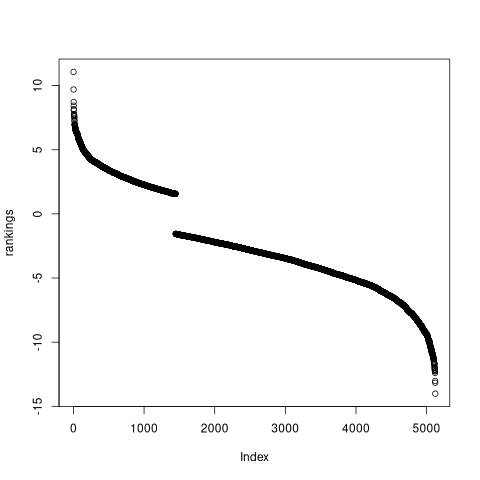

In [16]:
%%R

plot(rankings)

In [17]:
%%R

max(rankings)

[1] 11.06762


In [18]:
%%R

min(rankings)

[1] -14.01811


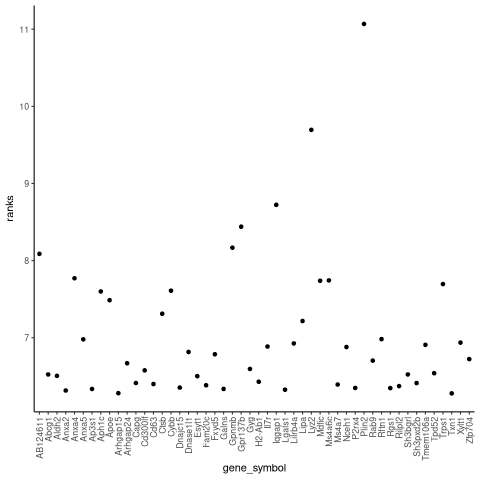

In [19]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [20]:
%%R

head(rankings)

    Plin2      Lyz2    Iqgap1   Gpr137b     Gpnmb  AB124611 
11.067619  9.694689  8.723017  8.439819  8.166847  8.087572 


## START BAM GSEA

In [21]:
%%R
fgsea_OPC <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In addition: Warning message:
In fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize,  :
  For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.


In [22]:
%%R
fgsea_OPC

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 8.501325e-06 1.812693e-04
 2:               HALLMARK_ALLOGRAFT_REJECTION 6.628749e-01 8.736215e-01
 3:                 HALLMARK_ANDROGEN_RESPONSE 3.448276e-02 8.103448e-02
 4:                   HALLMARK_APICAL_JUNCTION 5.181347e-02 1.159635e-01
 5:                         HALLMARK_APOPTOSIS 8.536526e-03 3.450451e-02
 6:              HALLMARK_BILE_ACID_METABOLISM 7.491601e-01 9.200979e-01
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 1.445443e-04 1.698395e-03
 8:                       HALLMARK_COAGULATION 2.940541e-01 4.606847e-01
 9:                        HALLMARK_COMPLEMENT 1.849989e-02 5.525910e-02
10:                        HALLMARK_DNA_REPAIR 1.977676e-02 5.525910e-02
11:                       HALLMARK_E2F_TARGETS 7.634855e-01 9.200979e-01
12: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 4.98

47:          Apoe,Aldh2,Idh1,Gcnt2,Cdo1,Xdh,...
                                    leadingEdge


In [23]:
%%R

# Filter for significant results with padj < 0.05
fgsea_OPC_significant <- fgsea_OPC %>% filter(padj < 0.1)
dim(fgsea_OPC_significant)

[1] 20  8


In [24]:
%%R
unique(fgsea_OPC_significant$pathway)

 [1] "HALLMARK_ADIPOGENESIS"                     
 [2] "HALLMARK_ANDROGEN_RESPONSE"                
 [3] "HALLMARK_APOPTOSIS"                        
 [4] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [5] "HALLMARK_COMPLEMENT"                       
 [6] "HALLMARK_DNA_REPAIR"                       
 [7] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
 [8] "HALLMARK_FATTY_ACID_METABOLISM"            
 [9] "HALLMARK_GLYCOLYSIS"                       
[10] "HALLMARK_HEDGEHOG_SIGNALING"               
[11] "HALLMARK_HYPOXIA"                          
[12] "HALLMARK_IL2_STAT5_SIGNALING"              
[13] "HALLMARK_KRAS_SIGNALING_DN"                
[14] "HALLMARK_MITOTIC_SPINDLE"                  
[15] "HALLMARK_NOTCH_SIGNALING"                  
[16] "HALLMARK_OXIDATIVE_PHOSPHORYLATION"        
[17] "HALLMARK_PROTEIN_SECRETION"                
[18] "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY"  
[19] "HALLMARK_TGF_BETA_SIGNALING"               
[20] "HALLMARK_UV_RESPONSE_DN"                   


## Explore specific gene sets

In [25]:
%%R

fgseaResTidy <- fgsea_OPC %>%
  as_tibble() %>%
  arrange(desc(NES))

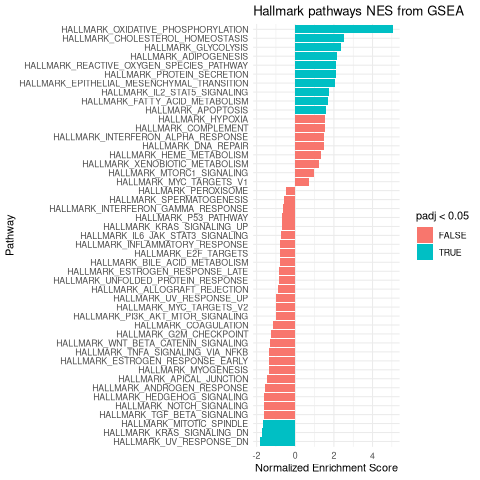

In [26]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [27]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                        padj   NES  size
  <chr>                                         <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION         6.17e-31  5.06    99
2 HALLMARK_GLYCOLYSIS                        1.81e- 4  2.39    68
3 HALLMARK_ADIPOGENESIS                      1.81e- 4  2.17    95
4 HALLMARK_CHOLESTEROL_HOMEOSTASIS           1.70e- 3  2.50    23
5 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 4.58e- 3  2.04    50
6 HALLMARK_UV_RESPONSE_DN                    4.58e- 3 -1.83    59


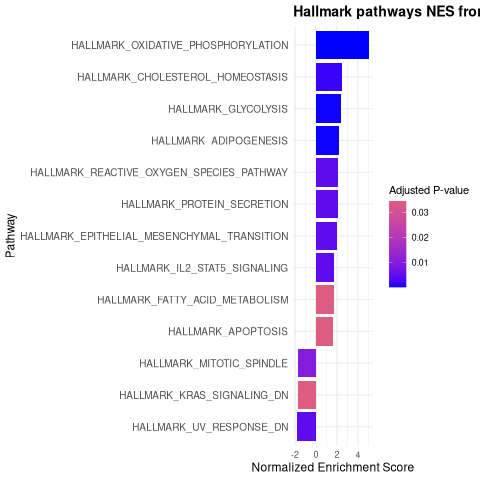

In [28]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

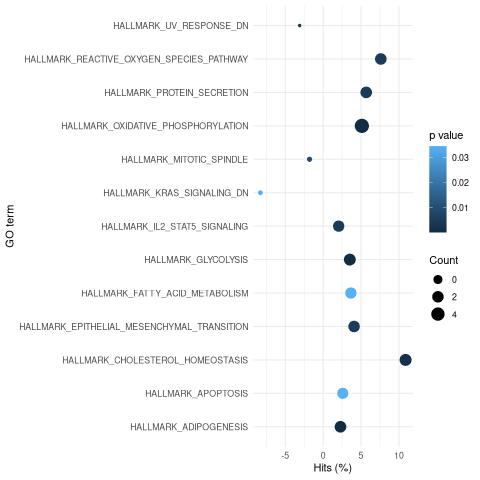

In [29]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [30]:
%%R

fgsea_OPC_significant

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 8.501325e-06 1.812693e-04
 2:                 HALLMARK_ANDROGEN_RESPONSE 3.448276e-02 8.103448e-02
 3:                         HALLMARK_APOPTOSIS 8.536526e-03 3.450451e-02
 4:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 1.445443e-04 1.698395e-03
 5:                        HALLMARK_COMPLEMENT 1.849989e-02 5.525910e-02
 6:                        HALLMARK_DNA_REPAIR 1.977676e-02 5.525910e-02
 7: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 4.988636e-04 4.581656e-03
 8:             HALLMARK_FATTY_ACID_METABOLISM 9.543802e-03 3.450451e-02
 9:                        HALLMARK_GLYCOLYSIS 1.157038e-05 1.812693e-04
10:                HALLMARK_HEDGEHOG_SIGNALING 3.159174e-02 7.814798e-02
11:                           HALLMARK_HYPOXIA 2.988776e-02 7.804026e-02
12:               HALLMARK_IL2_STAT5_SIGNALING 7.47

In [31]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

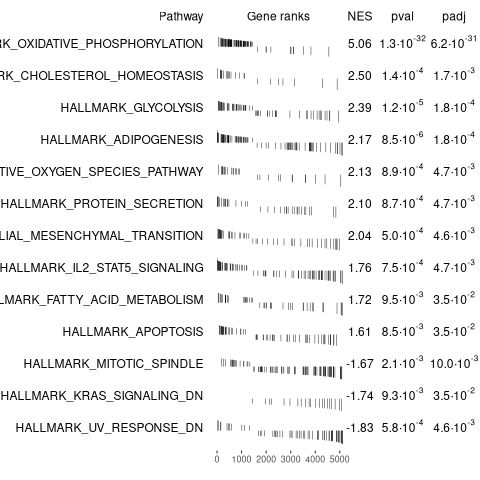

In [32]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

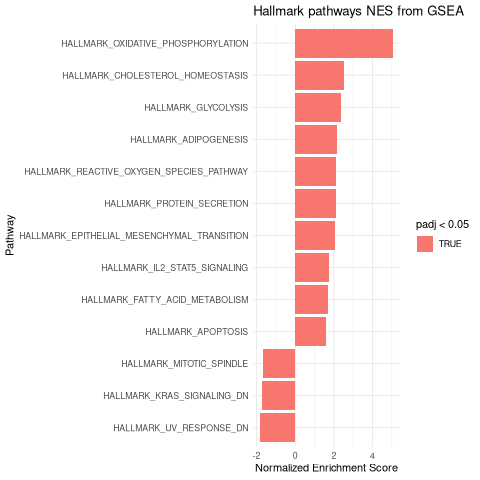

In [33]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj < 0.05)) +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal()

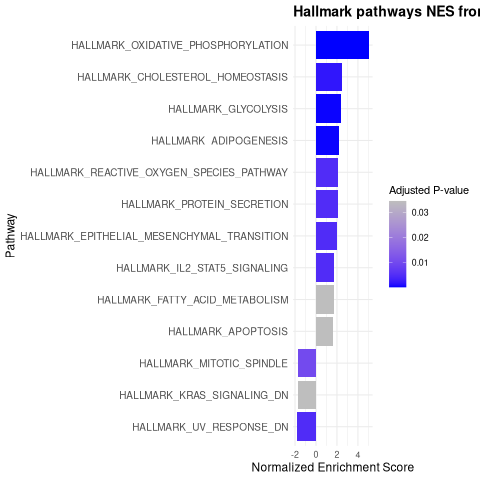

In [34]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "grey", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


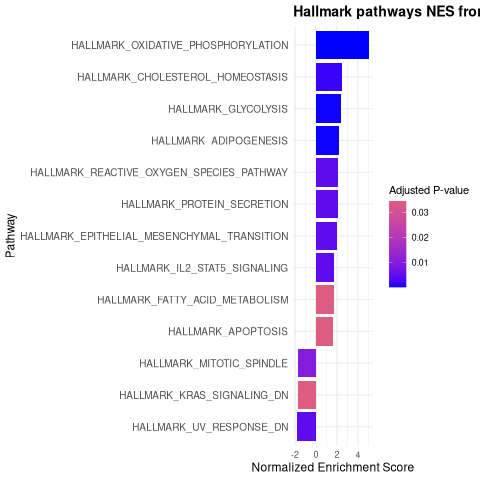

In [35]:
%%R

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [36]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgsea_OPC_significant$pathway <- gsub("^HALLMARK_", "", filtered_fgsea_OPC_significant$pathway)

# View the updated heatmap_df
head(filtered_fgsea_OPC_significant)

                             pathway         pval         padj   log2err
                              <char>        <num>        <num>     <num>
1:                      ADIPOGENESIS 8.501325e-06 0.0001812693 0.5933255
2:                         APOPTOSIS 8.536526e-03 0.0345045135 0.3807304
3:           CHOLESTEROL_HOMEOSTASIS 1.445443e-04 0.0016983951 0.5188481
4: EPITHELIAL_MESENCHYMAL_TRANSITION 4.988636e-04 0.0045816562 0.4772708
5:             FATTY_ACID_METABOLISM 9.543802e-03 0.0345045135 0.3807304
6:                        GLYCOLYSIS 1.157038e-05 0.0001812693 0.5933255
          ES      NES  size                             leadingEdge
       <num>    <num> <int>                                  <list>
1: 0.2556840 2.172977    95 Plin2,Apoe,Aldh2,Esyt1,Dnajc15,Idh1,...
2: 0.2132496 1.606209    62       Cd44,Psen2,Lgals3,Dap,Gsr,App,...
3: 0.4753865 2.501787    23   Anxa5,Lgals3,Gusb,Alcam,Lpl,Plaur,...
4: 0.2694179 2.039798    50    Capg,Lgals1,Vim,Mmp14,Cd44,Tgfbi,...
5: 0.236

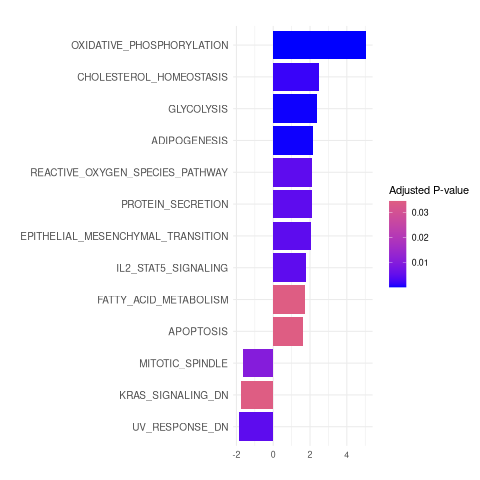

In [37]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_demyel_BAM_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [38]:
%%R

head(filtered_fgsea_OPC_significant)

                             pathway         pval         padj   log2err
                              <char>        <num>        <num>     <num>
1:                      ADIPOGENESIS 8.501325e-06 0.0001812693 0.5933255
2:                         APOPTOSIS 8.536526e-03 0.0345045135 0.3807304
3:           CHOLESTEROL_HOMEOSTASIS 1.445443e-04 0.0016983951 0.5188481
4: EPITHELIAL_MESENCHYMAL_TRANSITION 4.988636e-04 0.0045816562 0.4772708
5:             FATTY_ACID_METABOLISM 9.543802e-03 0.0345045135 0.3807304
6:                        GLYCOLYSIS 1.157038e-05 0.0001812693 0.5933255
          ES      NES  size                             leadingEdge
       <num>    <num> <int>                                  <list>
1: 0.2556840 2.172977    95 Plin2,Apoe,Aldh2,Esyt1,Dnajc15,Idh1,...
2: 0.2132496 1.606209    62       Cd44,Psen2,Lgals3,Dap,Gsr,App,...
3: 0.4753865 2.501787    23   Anxa5,Lgals3,Gusb,Alcam,Lpl,Plaur,...
4: 0.2694179 2.039798    50    Capg,Lgals1,Vim,Mmp14,Cd44,Tgfbi,...
5: 0.236

In [39]:
%%R
unique(filtered_fgsea_OPC_significant$pathway)

 [1] "ADIPOGENESIS"                      "APOPTOSIS"                        
 [3] "CHOLESTEROL_HOMEOSTASIS"           "EPITHELIAL_MESENCHYMAL_TRANSITION"
 [5] "FATTY_ACID_METABOLISM"             "GLYCOLYSIS"                       
 [7] "IL2_STAT5_SIGNALING"               "KRAS_SIGNALING_DN"                
 [9] "MITOTIC_SPINDLE"                   "OXIDATIVE_PHOSPHORYLATION"        
[11] "PROTEIN_SECRETION"                 "REACTIVE_OXYGEN_SPECIES_PATHWAY"  
[13] "UV_RESPONSE_DN"                   


In [40]:
%%R

# Define the pathway of interest
pathway_of_interest <- "CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Anxa5"  "Lgals3" "Gusb"   "Alcam"  "Lpl"    "Plaur"  "Fabp5"  "Plscr1"
 [9] "Ethe1"  "Pparg"  "Antxr2" "Cxcl16" "Tmem97" "Nfil3"  "Pmvk"   "Atf5"  


In [41]:
%%R

# Define the pathway of interest
pathway_of_interest <- "MITOTIC_SPINDLE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Rapgef5"  "Arap3"    "Bin1"     "Farp1"    "Arhgap5"  "Tiam1"   
 [7] "Dst"      "Arhgap4"  "Sun2"     "Arhgap27" "Stau1"    "Taok2"   
[13] "Marcks"   "Fscn1"    "Map1s"    "Ophn1"    "Mid1"     "Katna1"  
[19] "Cntrob"   "Epb41l2"  "Wasl"     "Dock4"    "Espl1"    "Arhgef2" 
[25] "Mapre1"   "Plekhg2"  "Map3k11"  "Nf1"      "Wasf2"    "Clip1"   
[31] "Trio"     "Rasa1"    "Kptn"     "Lats1"    "Csnk1d"   "Pdlim5"  
[37] "Abl1"     "Kif3b"    "Tubgcp5"  "Cdc27"    "Myh10"    "Rapgef6" 
[43] "Cd2ap"    "Hdac6"   


In [42]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [43]:
%%R

# Define the pathway of interest
pathway_of_interest <- "KRAS_SIGNALING_DN"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Msh5"    "Snn"     "Kcnd1"   "Ccdc106" "Lfng"    "Nr6a1"   "Btg2"   
 [8] "Prkn"    "Gpr19"   "Slc29a3" "Skil"    "Ypel1"   "Camk1d"  "Ptprj"  
[15] "Cd80"   


In [44]:
%%R

# Define the pathway of interest
pathway_of_interest <- "REACTIVE_OXYGEN_SPECIES_PATHWAY"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Txn1"    "Gsr"     "Lsp1"    "Gpx4"    "Glrx2"   "Prdx1"   "Ftl1"   
 [8] "Prdx6"   "Prdx4"   "Lamtor5" "Pfkp"    "Prdx2"   "Mgst1"   "Gpx3"   
[15] "Ndufb4"  "Atox1"  


In [45]:
%%R

# Define the pathway of interest
pathway_of_interest <- "UV_RESPONSE_DN"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Tjp1"    "Mgll"    "Bmpr1a"  "Ptprm"   "Kcnma1"  "Cacna1a" "Dlc1"   
 [8] "Prkca"   "Itgb3"   "Prkce"   "Smad7"   "Vav2"    "Sipa1l1" "Pik3cd" 
[15] "Tgfbr2"  "Inpp4b"  "Igf1r"   "Prdm2"   "Smad3"   "Atp2c1"  "Nr1d2"  
[22] "Wdr37"   "Ythdc1"  "Runx1"   "Pmp22"  


In [46]:
%%R

class(filtered_fgsea_OPC_significant)

[1] "data.table" "data.frame"


In [47]:
%%R

class(fgsea_OPC)

[1] "data.table" "data.frame"


In [48]:
%%R

filtered_fgsea_OPC_significant <- as.data.frame(filtered_fgsea_OPC_significant)

In [49]:
%%R
filtered_fgsea_OPC_significant

                             pathway         pval         padj   log2err
1                       ADIPOGENESIS 8.501325e-06 1.812693e-04 0.5933255
2                          APOPTOSIS 8.536526e-03 3.450451e-02 0.3807304
3            CHOLESTEROL_HOMEOSTASIS 1.445443e-04 1.698395e-03 0.5188481
4  EPITHELIAL_MESENCHYMAL_TRANSITION 4.988636e-04 4.581656e-03 0.4772708
5              FATTY_ACID_METABOLISM 9.543802e-03 3.450451e-02 0.3807304
6                         GLYCOLYSIS 1.157038e-05 1.812693e-04 0.5933255
7                IL2_STAT5_SIGNALING 7.477501e-04 4.656889e-03 0.4772708
8                  KRAS_SIGNALING_DN 9.317883e-03 3.450451e-02 0.3807304
9                    MITOTIC_SPINDLE 2.122213e-03 9.974399e-03 0.4317077
10         OXIDATIVE_PHOSPHORYLATION 1.311913e-32 6.165993e-31 1.4815676
11                 PROTEIN_SECRETION 8.691858e-04 4.656889e-03 0.4772708
12   REACTIVE_OXYGEN_SPECIES_PATHWAY 8.917447e-04 4.656889e-03 0.4772708
13                    UV_RESPONSE_DN 5.848923e-04 4

10 Idh1, Ndufb2, Echs1, Atp6v0e, Ndufb8, Polr2f, Gpx4, Mrpl15, Ndufb7, Bax, Ndufv2, Atp5g2, Hsd17b10, Atp5c1, Sdhd, Ndufab1, Ndufc1, Cox7b, Cox17, Atp6v1c1, Uqcr10, Ndufa7, Mpc1, Acaa2, Cox5a, Cox6a1, Atp5l, Ndufa2, Timm13, Cox7a2, Cox7c, Atp6v1f, Atp5j, Cox4i1, Atp6v1g1, Ndufa1, Ndufb6, Ndufa3, Ndufb5, Mrpl34, Atp5j2, Cox6b1, Uqcrq, Phyh, Mrps12, Cox6c, Timm8b, Ndufs4, Atp5g3, Ndufa4, Cox5b, Ndufb4, Ndufa5, Gpi1, Etfa, Timm17a, Cox8a, Atp5k, Uqcrh, Fxn, Dlat, Grpel1, Ndufb3, Atp5o, Mrpl11, Tomm22, Slc25a4, Ndufc2, Etfb, Sdhc, Atp5d, Sdhb, Vdac1, Idh3b, Ldha, Got2, Ndufs6, Atp5g1, Atp5h, Decr1, Uqcr11, Ndufa8, Atp5e, Nqo2, Uqcrfs1, Cyb5r3, Mrpl35, Mdh2
11                                                                                                                                                                                                                                                                                                                                                 

In [50]:
%%R
library(data.table)
fwrite(filtered_fgsea_OPC_significant, file = "./files/filtered_fgsea_LPC_demyel_BAM_significant_NEW.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [51]:
%%R

fwrite(fgsea_OPC, file = "./files/fgsea_LPC_demyel_BAM_all.csv")

# LPC_demyel_DAMs

In [52]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_demyel_Mg_A_v_trt_voom_wqw_NEW.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

           gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
1       Tspan18 -4.766999 2.874435 -23.33149 2.097323e-11 2.235537e-07 16.03800
2       Gm10790 -3.805976 6.793027 -19.63986 1.593161e-10 4.709936e-07 14.72040
3        Cacnb2 -5.049577 6.066487 -19.14628 2.146491e-10 4.709936e-07 14.43728
4 C430049B03Rik -5.118048 3.014768 -18.87276 2.540001e-10 4.709936e-07 13.93965
5       Ifitm10 -3.446056 6.819770 -18.65461 2.909768e-10 4.709936e-07 14.12595
6       Clec4a2 -3.865865 3.014266 -18.62810 2.958524e-10 4.709936e-07 13.85647


In [53]:
%%R

dim(df)

[1] 10659     7


In [54]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Tspan18"       "Gm10790"       "Cacnb2"        "C430049B03Rik"
[5] "Ifitm10"       "Clec4a2"      


In [55]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [56]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [57]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


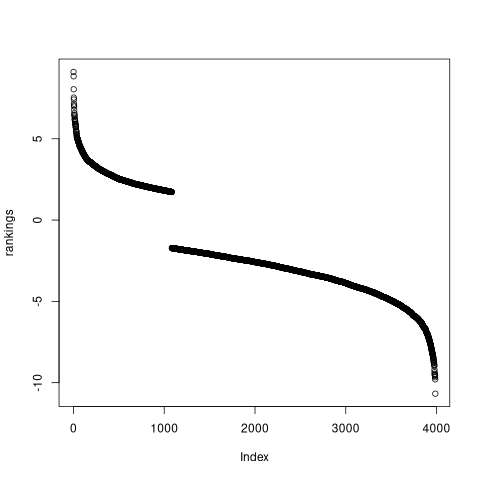

In [58]:
%%R

plot(rankings)

In [59]:
%%R

max(rankings)

[1] 9.111081


In [60]:
%%R

min(rankings)

[1] -10.67833


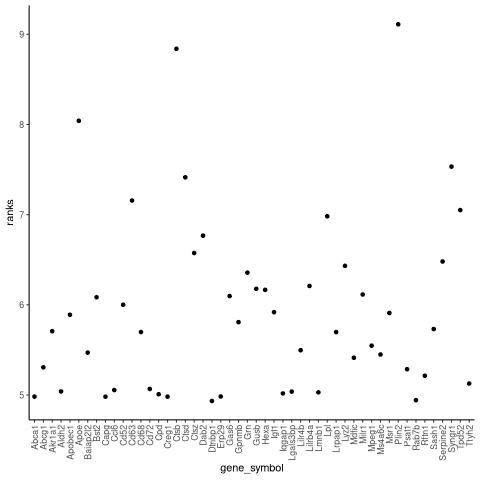

In [61]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [62]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [63]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 2.128333e-06 3.121555e-05
 2:               HALLMARK_ALLOGRAFT_REJECTION 3.295455e-01 4.833333e-01
 3:                 HALLMARK_ANDROGEN_RESPONSE 2.247706e-01 3.410313e-01
 4:                   HALLMARK_APICAL_JUNCTION 9.628009e-01 9.628009e-01
 5:                         HALLMARK_APOPTOSIS 4.912296e-02 1.029243e-01
 6:              HALLMARK_BILE_ACID_METABOLISM 9.574970e-01 9.628009e-01
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 1.596523e-03 6.386091e-03
 8:                       HALLMARK_COAGULATION 1.263332e-01 2.316109e-01
 9:                        HALLMARK_COMPLEMENT 3.727569e-02 1.007196e-01
10:                        HALLMARK_DNA_REPAIR 1.188986e-01 2.274582e-01
11:                       HALLMARK_E2F_TARGETS 4.166667e-01 5.729167e-01
12: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 2.74

In [64]:
%%R

library(data.table)
fwrite(fgsea_res, file = "./files/fgsea_LPC_demyel_DAMs_all.csv")

In [65]:
%%R

dim(fgsea_res)

[1] 44  8


In [66]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL2_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL2_significant)

[1] 15  8


In [67]:
%%R

head(fgsea_MOL2_significant)

                                      pathway         pval         padj
                                       <char>        <num>        <num>
1:                      HALLMARK_ADIPOGENESIS 2.128333e-06 3.121555e-05
2:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 1.596523e-03 6.386091e-03
3: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 2.741160e-04 1.507638e-03
4:             HALLMARK_FATTY_ACID_METABOLISM 4.020951e-05 3.538437e-04
5:                        HALLMARK_GLYCOLYSIS 2.124524e-07 4.673954e-06
6:                           HALLMARK_HYPOXIA 3.965012e-03 1.342004e-02
     log2err        ES      NES  size                              leadingEdge
       <num>     <num>    <num> <int>                                   <list>
1: 0.6272567 0.2926931 2.622265    73      Plin2,Apoe,Lpl,Aldh2,Abca1,Ucp2,...
2: 0.4550599 0.4812149 2.208399    15   Lpl,Gusb,Anxa5,Lgals3,Cxcl16,Fabp5,...
3: 0.4984931 0.3612512 2.305787    32 Dab2,Serpine2,Capg,Fuca1,Tpm4,Lgals1,...
4: 0.5573322 0.3899035 2.4444

In [68]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL2_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

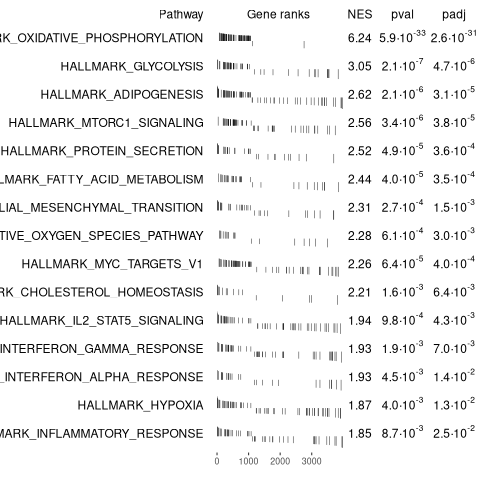

In [69]:
%%R

mainPathways <- fgsea_MOL2_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL2_significant, 
              gseaParam = 0.5)

In [70]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

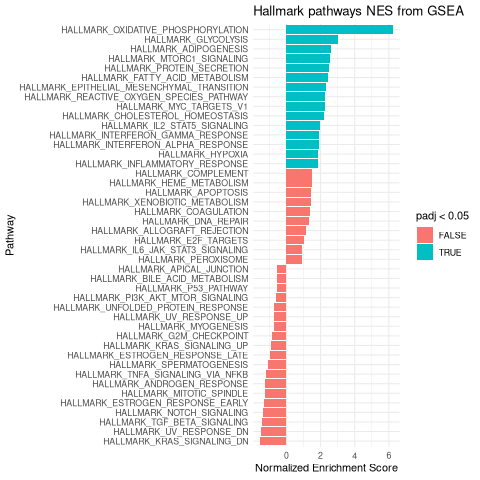

In [71]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [72]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION 2.60e-31  6.24    70
2 HALLMARK_GLYCOLYSIS                4.67e- 6  3.05    50
3 HALLMARK_ADIPOGENESIS              3.12e- 5  2.62    73
4 HALLMARK_MTORC1_SIGNALING          3.77e- 5  2.56    57
5 HALLMARK_FATTY_ACID_METABOLISM     3.54e- 4  2.44    33
6 HALLMARK_PROTEIN_SECRETION         3.57e- 4  2.52    29


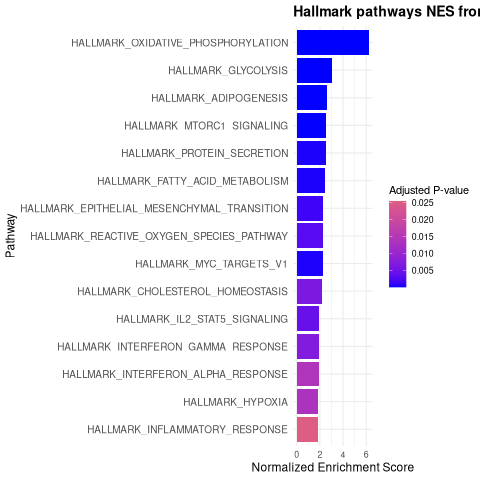

In [73]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

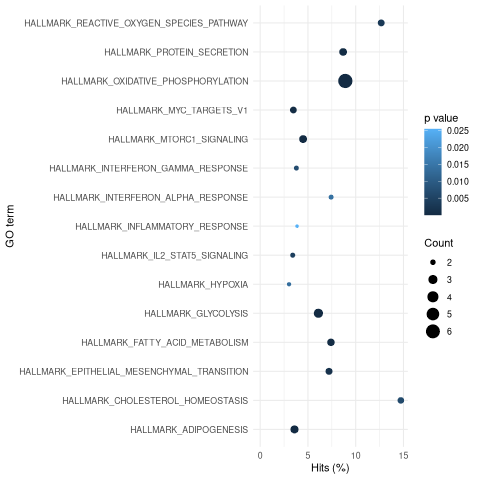

In [74]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [75]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION 2.60e-31  6.24    70
2 HALLMARK_GLYCOLYSIS                4.67e- 6  3.05    50
3 HALLMARK_ADIPOGENESIS              3.12e- 5  2.62    73
4 HALLMARK_MTORC1_SIGNALING          3.77e- 5  2.56    57
5 HALLMARK_FATTY_ACID_METABOLISM     3.54e- 4  2.44    33
6 HALLMARK_PROTEIN_SECRETION         3.57e- 4  2.52    29


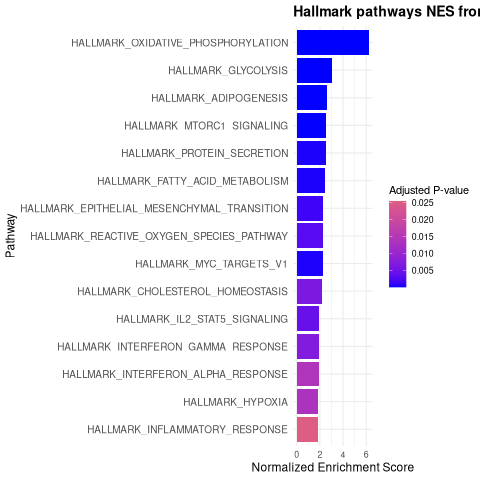

In [76]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


In [77]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 6 × 4
  pathway                       padj   NES  size
  <chr>                        <dbl> <dbl> <int>
1 OXIDATIVE_PHOSPHORYLATION 2.60e-31  6.24    70
2 GLYCOLYSIS                4.67e- 6  3.05    50
3 ADIPOGENESIS              3.12e- 5  2.62    73
4 MTORC1_SIGNALING          3.77e- 5  2.56    57
5 FATTY_ACID_METABOLISM     3.54e- 4  2.44    33
6 PROTEIN_SECRETION         3.57e- 4  2.52    29


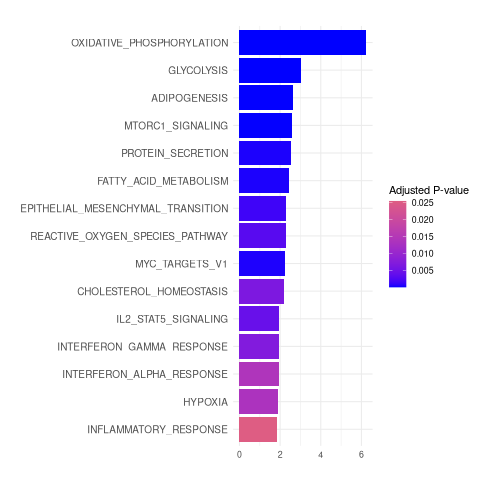

In [78]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_demyel_DAM_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [79]:
%%R
unique(fgsea_MOL2_significant$pathway)

 [1] "HALLMARK_ADIPOGENESIS"                     
 [2] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [3] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
 [4] "HALLMARK_FATTY_ACID_METABOLISM"            
 [5] "HALLMARK_GLYCOLYSIS"                       
 [6] "HALLMARK_HYPOXIA"                          
 [7] "HALLMARK_IL2_STAT5_SIGNALING"              
 [8] "HALLMARK_INFLAMMATORY_RESPONSE"            
 [9] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[10] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
[11] "HALLMARK_MTORC1_SIGNALING"                 
[12] "HALLMARK_MYC_TARGETS_V1"                   
[13] "HALLMARK_OXIDATIVE_PHOSPHORYLATION"        
[14] "HALLMARK_PROTEIN_SECRETION"                
[15] "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY"  


In [80]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Lpl"    "Gusb"   "Anxa5"  "Lgals3" "Cxcl16" "Fabp5"  "Cd9"    "Dhcr7" 
 [9] "Pmvk"   "Ethe1" 


In [81]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_PROTEIN_SECRETION"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cd63"   "Tpd52"  "Abca1"  "Tmed10" "Ap3s1"  "Igf2r"  "Galc"   "Ap2s1" 
 [9] "Bet1"   "Rab9"   "Sgms1"  "Ctsc"   "Pam"   


In [82]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_NOTCH_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [83]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_COAGULATION"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [84]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INFLAMMATORY_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Bst2"    "Msr1"    "Abca1"   "Hif1a"   "Cybb"    "Ly6e"    "Ptger4" 
 [8] "Cd14"    "P2rx4"   "Axl"     "Slc31a2" "Adgre1"  "Sri"     "Csf1"   
[15] "Il1b"    "Ifnar1" 


In [85]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Bst2"     "Lgals3bp" "Psme2"    "Ly6e"     "Psmb8"    "Psme1"   
 [7] "Ifitm3"   "Lap3"     "Ifi30"    "Csf1"     "B2m"      "Mvb12a"  


In [86]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_KRAS_SIGNALING_DN"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [87]:
%%R

fgsea_MOL2_significant <- as.data.frame(fgsea_MOL2_significant)

In [88]:
%%R
library(data.table)
fwrite(fgsea_MOL2_significant, file = "./files/filtered_fgseaResSignificant_LPC_demyel_DAMs.csv")

# LPC_remyel_DAMs

In [9]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_remyel_MG_DAMs_voom_wqw.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

           gene     logFC   AveExpr         t      P.Value    adj.P.Val
1          Apoe  7.579554 13.025590  42.68915 6.326895e-11 6.553398e-07
2          Lyz2  4.109261 10.634414  20.00434 2.990081e-08 1.548563e-04
3 8030442B05Rik -3.372194  5.245436 -17.92434 7.224905e-08 1.928765e-04
4       Slc24a3 -2.959040  5.993408 -17.48802 8.802149e-08 1.928765e-04
5          Cd63  3.098645  9.397423  17.36582 9.310507e-08 1.928765e-04
6        Plxna4 -2.834770  6.425026 -16.33665 1.517251e-07 2.289283e-04
          B
1 13.795370
2  9.628199
3  8.691354
4  8.630933
5  8.599270
6  8.169388


In [10]:
%%R

dim(df)

[1] 10358     7


In [11]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Apoe"          "Lyz2"          "8030442B05Rik" "Slc24a3"      
[5] "Cd63"          "Plxna4"       


In [12]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [13]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [14]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


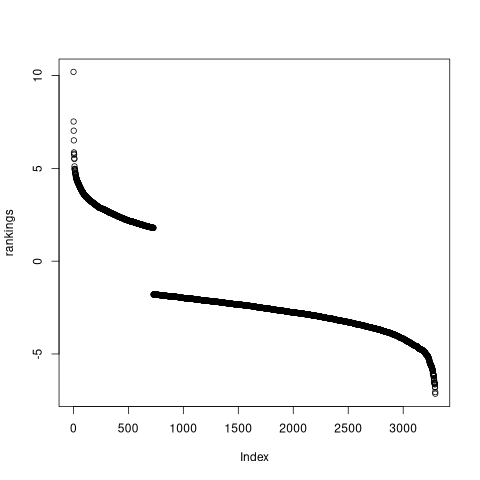

In [15]:
%%R

plot(rankings)

In [16]:
%%R

max(rankings)

[1] 10.19881


In [17]:
%%R

min(rankings)

[1] -7.141168


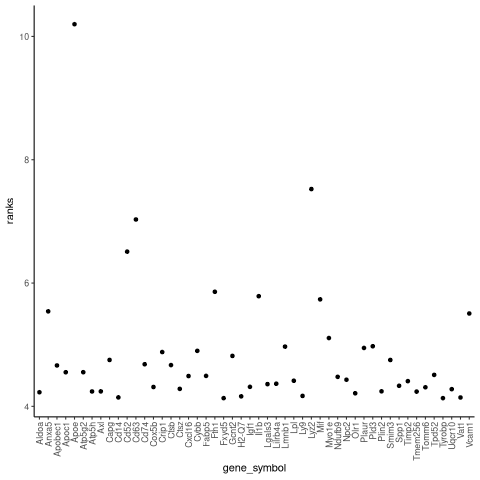

In [18]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [19]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [20]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 3.441212e-07 2.408849e-06
 2:               HALLMARK_ALLOGRAFT_REJECTION 8.494730e-06 3.654825e-05
 3:                 HALLMARK_ANDROGEN_RESPONSE 1.785268e-01 2.318952e-01
 4:                   HALLMARK_APICAL_JUNCTION 1.799747e-01 2.318952e-01
 5:                         HALLMARK_APOPTOSIS 1.487652e-02 2.603390e-02
 6:              HALLMARK_BILE_ACID_METABOLISM 7.506631e-01 8.069663e-01
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 4.593282e-06 2.411473e-05
 8:                       HALLMARK_COAGULATION 3.738546e-04 9.646237e-04
 9:                        HALLMARK_COMPLEMENT 2.862114e-07 2.404176e-06
10:                        HALLMARK_DNA_REPAIR 8.067599e-03 1.613520e-02
11:                       HALLMARK_E2F_TARGETS 9.987516e-01 9.987516e-01
12: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 1.75

In [21]:
%%R

dim(fgsea_res)

[1] 42  8


In [22]:
%%R

library(data.table)
fwrite(fgsea_res, file = "./files/fgsea_LPC_remyel_DAMs_all.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [23]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL4_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL4_significant)

[1] 27  8


In [24]:
%%R

head(fgsea_MOL4_significant)

                            pathway         pval         padj   log2err
                             <char>        <num>        <num>     <num>
1:            HALLMARK_ADIPOGENESIS 3.441212e-07 2.408849e-06 0.6749629
2:     HALLMARK_ALLOGRAFT_REJECTION 8.494730e-06 3.654825e-05 0.5933255
3:               HALLMARK_APOPTOSIS 1.487652e-02 2.603390e-02 0.3807304
4: HALLMARK_CHOLESTEROL_HOMEOSTASIS 4.593282e-06 2.411473e-05 0.6105269
5:             HALLMARK_COAGULATION 3.738546e-04 9.646237e-04 0.4984931
6:              HALLMARK_COMPLEMENT 2.862114e-07 2.404176e-06 0.6749629
          ES      NES  size                             leadingEdge
       <num>    <num> <int>                                  <list>
1: 0.3422422 2.888073    62   Apoe,Lpl,Uqcr10,Plin2,Aldoa,Cox8a,...
2: 0.3157026 2.582066    57      Il1b,Capg,Cd74,Tpd52,H2-Q7,Fgr,...
3: 0.2219360 1.723908    44  Il1b,Timp2,Lgals3,Cd14,Cdkn1a,Sod2,...
4: 0.5518370 2.852875    20 Anxa5,Plaur,Fabp5,Cxcl16,Lpl,Lgals3,...
5: 0.3804971 2.3

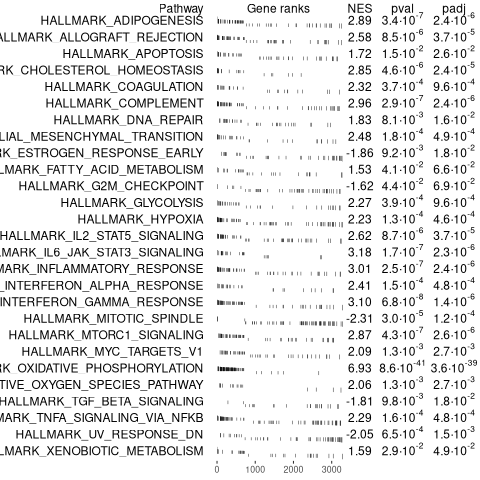

In [25]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL4_significant$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

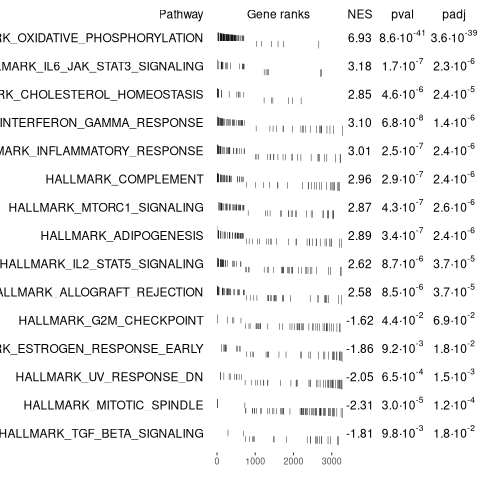

In [26]:
%%R

topUp <- fgsea_MOL4_significant %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)

topDown <- fgsea_MOL4_significant %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)

topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)

plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [27]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL4_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

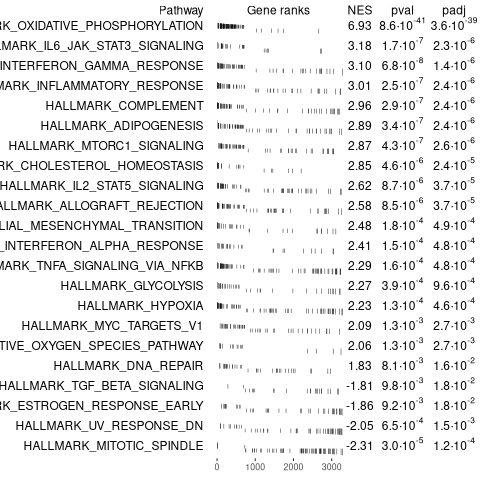

In [28]:
%%R

mainPathways <- fgsea_MOL4_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [29]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

In [30]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION 3.60e-39  6.93    77
2 HALLMARK_INTERFERON_GAMMA_RESPONSE 1.42e- 6  3.10    56
3 HALLMARK_IL6_JAK_STAT3_SIGNALING   2.34e- 6  3.18    24
4 HALLMARK_INFLAMMATORY_RESPONSE     2.40e- 6  3.01    54
5 HALLMARK_COMPLEMENT                2.40e- 6  2.96    56
6 HALLMARK_ADIPOGENESIS              2.41e- 6  2.89    62


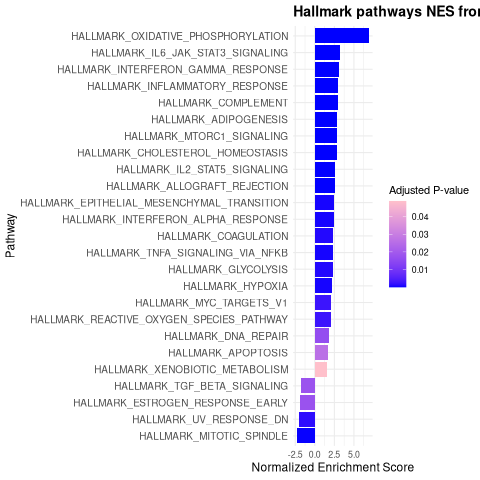

In [31]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "pink", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

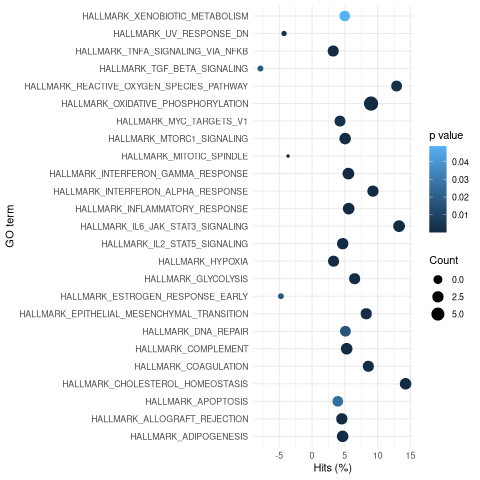

In [32]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [33]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION 3.60e-39  6.93    77
2 HALLMARK_INTERFERON_GAMMA_RESPONSE 1.42e- 6  3.10    56
3 HALLMARK_IL6_JAK_STAT3_SIGNALING   2.34e- 6  3.18    24
4 HALLMARK_INFLAMMATORY_RESPONSE     2.40e- 6  3.01    54
5 HALLMARK_COMPLEMENT                2.40e- 6  2.96    56
6 HALLMARK_ADIPOGENESIS              2.41e- 6  2.89    62


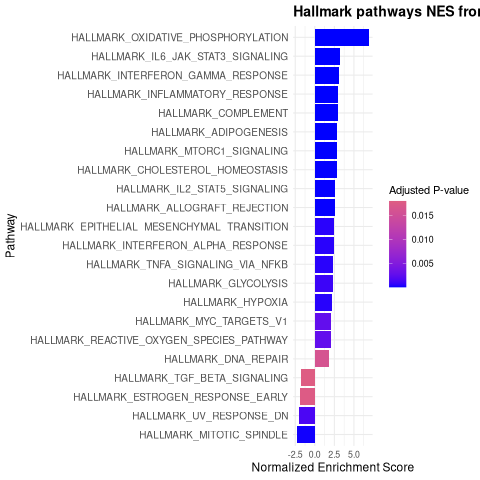

In [34]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


In [35]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 6 × 4
  pathway                       padj   NES  size
  <chr>                        <dbl> <dbl> <int>
1 OXIDATIVE_PHOSPHORYLATION 3.60e-39  6.93    77
2 INTERFERON_GAMMA_RESPONSE 1.42e- 6  3.10    56
3 IL6_JAK_STAT3_SIGNALING   2.34e- 6  3.18    24
4 INFLAMMATORY_RESPONSE     2.40e- 6  3.01    54
5 COMPLEMENT                2.40e- 6  2.96    56
6 ADIPOGENESIS              2.41e- 6  2.89    62


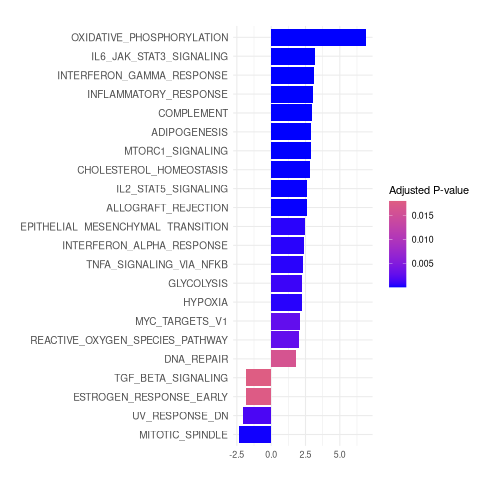

In [36]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_remyel_DAM_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

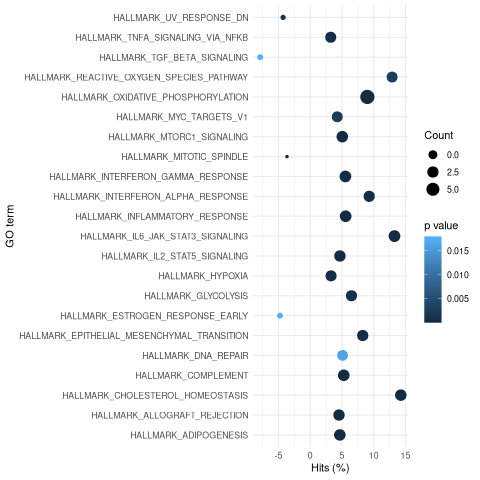

In [37]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Calculate hits percentage
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(filtered_fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()


In [38]:
%%R
unique(fgsea_MOL4_significant$pathway)

 [1] "HALLMARK_ADIPOGENESIS"                     
 [2] "HALLMARK_ALLOGRAFT_REJECTION"              
 [3] "HALLMARK_APOPTOSIS"                        
 [4] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [5] "HALLMARK_COAGULATION"                      
 [6] "HALLMARK_COMPLEMENT"                       
 [7] "HALLMARK_DNA_REPAIR"                       
 [8] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
 [9] "HALLMARK_ESTROGEN_RESPONSE_EARLY"          
[10] "HALLMARK_FATTY_ACID_METABOLISM"            
[11] "HALLMARK_G2M_CHECKPOINT"                   
[12] "HALLMARK_GLYCOLYSIS"                       
[13] "HALLMARK_HYPOXIA"                          
[14] "HALLMARK_IL2_STAT5_SIGNALING"              
[15] "HALLMARK_IL6_JAK_STAT3_SIGNALING"          
[16] "HALLMARK_INFLAMMATORY_RESPONSE"            
[17] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[18] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
[19] "HALLMARK_MITOTIC_SPINDLE"                  
[20] "HALLMARK_MTORC1_SIGNALING"                 


In [39]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Il1b"    "Cd14"    "Pim1"    "Cxcl2"   "Cd9"     "Cxcl10"  "Il3ra"  
 [8] "Csf2ra"  "Cd44"    "Tlr2"    "Csf1"    "Crlf2"   "Cxcl9"   "Acvrl1" 
[15] "Csf2rb2" "Cd36"    "Il2rg"   "Ifnar1" 


In [40]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_IL2_STAT5_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Myo1e"   "Capg"    "Spp1"    "Ctsz"    "Plin2"   "Maff"    "Anxa4"  
 [8] "Cd48"    "Pim1"    "Nfil3"   "Cxcl10"  "Il3ra"   "Gpr65"   "P2rx4"  
[15] "Cd83"    "Bhlhe40" "Cd44"    "Dhrs3"   "Csf1"   


In [41]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_PROTEIN_SECRETION"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [42]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Il1b"    "Plaur"   "Olr1"    "Cdkn1a"  "Ptger4"  "Maff"    "Sod2"   
 [8] "Nfil3"   "Cxcl2"   "Cxcl10"  "Cebpb"   "Nfe2l2"  "Ccl4"    "Cd83"   
[15] "Bhlhe40" "Ccl5"    "Cd44"    "Tlr2"    "Bcl2a1a" "Csf1"    "Bcl3"   
[22] "Cd69"    "Abca1"   "Dram1"   "Slc2a6"  "Tnip1"  


In [43]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Vcam1"    "Cd74"     "H2-Q7"    "Lgals3bp" "Cdkn1a"   "Sod2"    
 [7] "Pim1"     "H2-D1"    "Ifi30"    "Cxcl10"   "H2-M3"    "B2m"     
[13] "Psme2"    "Ccl5"     "Ifitm2"   "Psmb8"    "Cd69"     "Bst2"    
[19] "Lap3"     "Mt2"      "Vamp8"    "Hif1a"    "Trim25"   "Fgl2"    
[25] "Cd274"    "Psme1"    "H2-Aa"    "Cxcl9"    "Slamf7"   "Sri"     
[31] "Casp1"    "Psma2"    "Psmb9"    "Csf2rb2" 


In [44]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cd74"     "H2-Q7"    "Lgals3bp" "Ifi30"    "Cxcl10"   "B2m"     
 [7] "Psme2"    "Ifitm2"   "Psmb8"    "Csf1"     "Bst2"     "Lap3"    
[13] "Trim25"   "Psme1"    "Casp1"    "Psmb9"   


In [45]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_COAGULATION"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Ctsb"    "Apoc1"   "Olr1"    "Maff"    "Cd9"     "Apoc2"   "Fn1"    
 [8] "C3"      "Fyn"     "Mmp14"   "S100a13" "Ctse"    "Cpq"     "C1qa"   


In [46]:
%%R

fgsea_MOL4_significant <- as.data.frame(fgsea_MOL4_significant)

In [47]:
%%R
library(data.table)
fwrite(fgsea_MOL4_significant, file = "./files/filtered_fgseaResSignificant_LPC_remyel_DAMs.csv")

# Cupr_demyel_DAMs

In [9]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/Cupr_demyel_Mg_A_v_trt_voom_wqw_NEW.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

     gene     logFC   AveExpr         t      P.Value    adj.P.Val        B
1     Lpl  6.400062  7.558633  35.10537 3.170601e-13 3.217526e-09 19.45604
2     Gp9 -4.315409  2.874037 -31.47961 1.121661e-12 5.691310e-09 19.50572
3   Upk1b -4.717137  3.372472 -28.52588 3.505037e-12 1.036718e-08 18.47025
4    Apoe  6.265309 12.951242  28.14930 4.086393e-12 1.036718e-08 17.78625
5 Gm32036 -3.383772  4.617496 -27.05140 6.467257e-12 1.312594e-08 17.86873
6    Ggt5 -3.008927  3.185956 -26.02800 1.008731e-11 1.706101e-08 17.39903


In [10]:
%%R

dim(df)

[1] 10148     7


In [11]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Lpl"     "Gp9"     "Upk1b"   "Apoe"    "Gm32036" "Ggt5"   


In [12]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [13]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [14]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


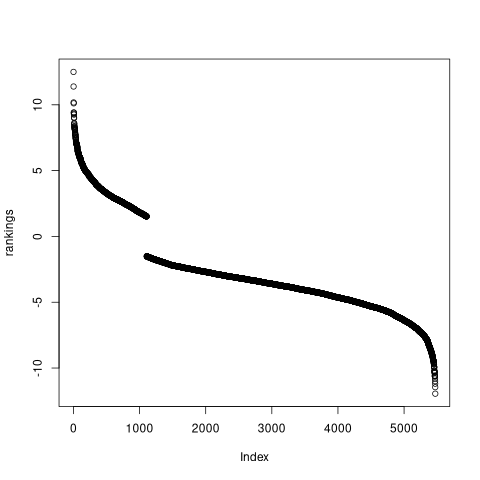

In [15]:
%%R

plot(rankings)

In [16]:
%%R

max(rankings)

[1] 12.49886


In [17]:
%%R

min(rankings)

[1] -11.95014


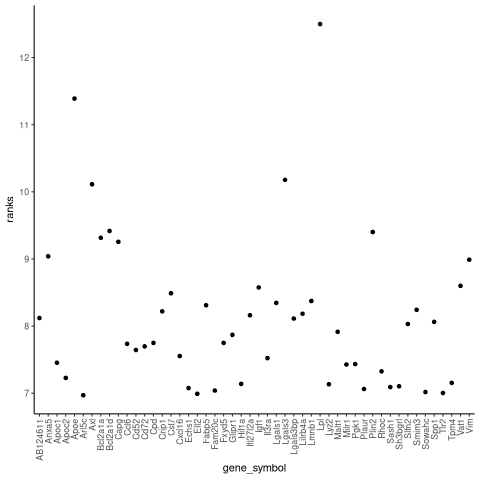

In [18]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [19]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [20]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 1.379767e-03 3.035488e-03
 2:               HALLMARK_ALLOGRAFT_REJECTION 2.317601e-06 7.844187e-06
 3:                 HALLMARK_ANDROGEN_RESPONSE 7.279822e-01 8.228906e-01
 4:                   HALLMARK_APICAL_JUNCTION 6.890849e-01 8.206333e-01
 5:                         HALLMARK_APOPTOSIS 2.814797e-05 7.740691e-05
 6:              HALLMARK_BILE_ACID_METABOLISM 2.307692e-01 3.760684e-01
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 7.286945e-10 4.580365e-09
 8:                       HALLMARK_COAGULATION 4.061605e-05 1.051239e-04
 9:                        HALLMARK_COMPLEMENT 3.171503e-08 1.395461e-07
10:                        HALLMARK_DNA_REPAIR 9.834620e-01 9.834620e-01
11:                       HALLMARK_E2F_TARGETS 2.367006e-04 5.786014e-04
12: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 1.28

In [21]:
%%R

dim(fgsea_res)

[1] 44  8


In [22]:
%%R

library(data.table)
fwrite(fgsea_res, file = "./files/fgsea_Cupr_demyel_DAMs_all.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [23]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL4_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL4_significant)

[1] 23  8


In [24]:
%%R

head(fgsea_MOL4_significant)

                            pathway         pval         padj   log2err
                             <char>        <num>        <num>     <num>
1:            HALLMARK_ADIPOGENESIS 1.379767e-03 3.035488e-03 0.4550599
2:     HALLMARK_ALLOGRAFT_REJECTION 2.317601e-06 7.844187e-06 0.6272567
3:               HALLMARK_APOPTOSIS 2.814797e-05 7.740691e-05 0.5756103
4: HALLMARK_CHOLESTEROL_HOMEOSTASIS 7.286945e-10 4.580365e-09 0.8012156
5:             HALLMARK_COAGULATION 4.061605e-05 1.051239e-04 0.5573322
6:              HALLMARK_COMPLEMENT 3.171503e-08 1.395461e-07 0.7195128
          ES      NES  size                             leadingEdge
       <num>    <num> <int>                                  <list>
1: 0.2154710 1.722527    85   Lpl,Apoe,Plin2,Echs1,Sowahc,Abca1,...
2: 0.3104150 2.509605    67     Capg,Hif1a,Tlr2,Csf1,Gpr65,Il1b,...
3: 0.3056639 2.315812    57    Lgals3,Tspo,Ifitm3,Il1b,Ank,Cd69,...
4: 0.6098135 3.498681    28 Lpl,Lgals3,Anxa5,Fabp5,Cxcl16,Plaur,...
5: 0.3675830 2.4

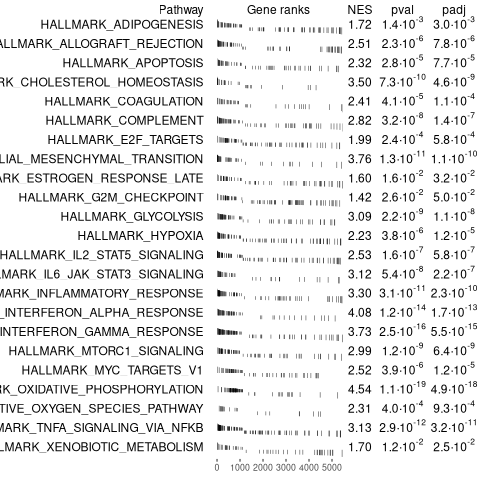

In [25]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL4_significant$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

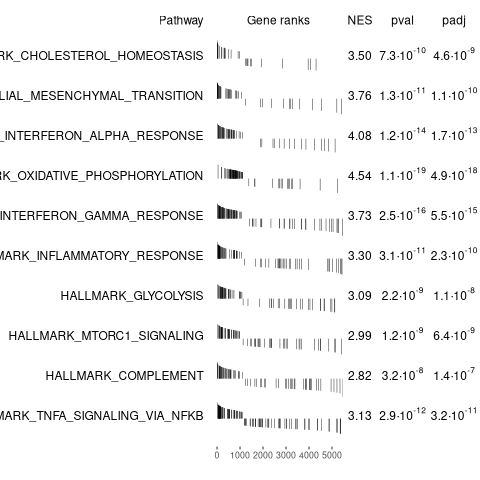

In [26]:
%%R

topUp <- fgsea_MOL4_significant %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)

topDown <- fgsea_MOL4_significant %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)

topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)

plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [27]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL4_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

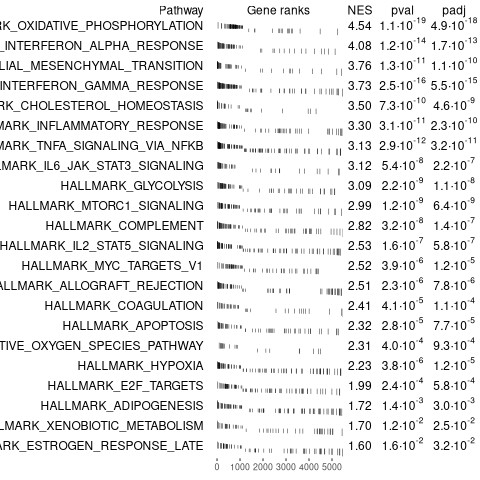

In [28]:
%%R

mainPathways <- fgsea_MOL4_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [29]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

In [30]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                        padj   NES  size
  <chr>                                         <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION         4.94e-18  4.54    75
2 HALLMARK_INTERFERON_GAMMA_RESPONSE         5.48e-15  3.73    89
3 HALLMARK_INTERFERON_ALPHA_RESPONSE         1.71e-13  4.08    54
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB           3.23e-11  3.13   105
5 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 1.13e-10  3.76    41
6 HALLMARK_INFLAMMATORY_RESPONSE             2.26e-10  3.30    74


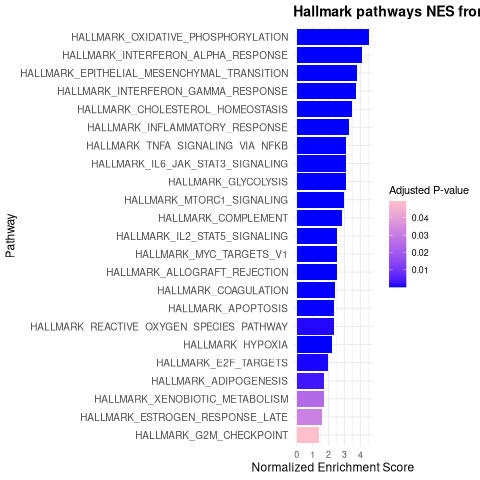

In [31]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "pink", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

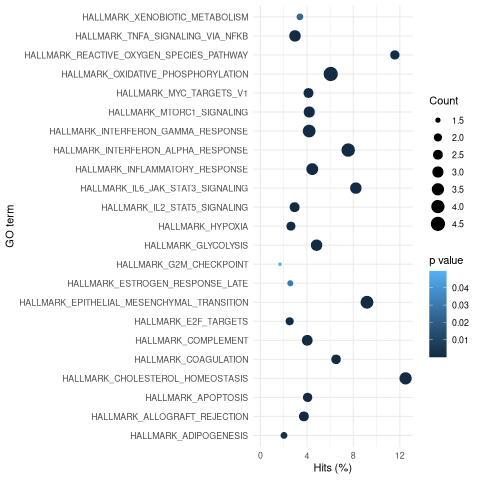

In [32]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [33]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                        padj   NES  size
  <chr>                                         <dbl> <dbl> <int>
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION         4.94e-18  4.54    75
2 HALLMARK_INTERFERON_GAMMA_RESPONSE         5.48e-15  3.73    89
3 HALLMARK_INTERFERON_ALPHA_RESPONSE         1.71e-13  4.08    54
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB           3.23e-11  3.13   105
5 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 1.13e-10  3.76    41
6 HALLMARK_INFLAMMATORY_RESPONSE             2.26e-10  3.30    74


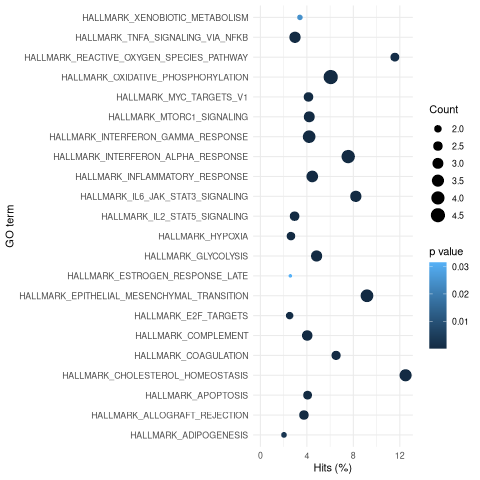

In [34]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Calculate hits percentage
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(filtered_fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()


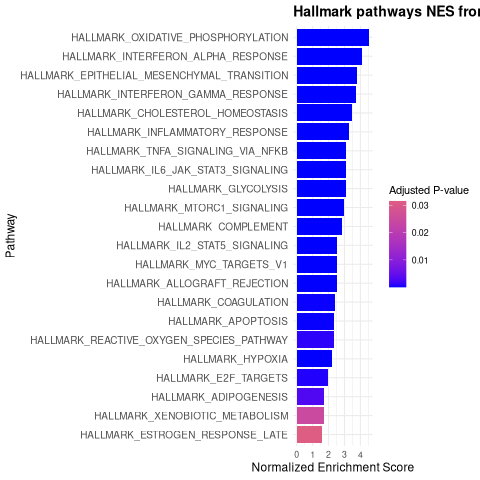

In [35]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [36]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 6 × 4
  pathway                               padj   NES  size
  <chr>                                <dbl> <dbl> <int>
1 OXIDATIVE_PHOSPHORYLATION         4.94e-18  4.54    75
2 INTERFERON_GAMMA_RESPONSE         5.48e-15  3.73    89
3 INTERFERON_ALPHA_RESPONSE         1.71e-13  4.08    54
4 TNFA_SIGNALING_VIA_NFKB           3.23e-11  3.13   105
5 EPITHELIAL_MESENCHYMAL_TRANSITION 1.13e-10  3.76    41
6 INFLAMMATORY_RESPONSE             2.26e-10  3.30    74


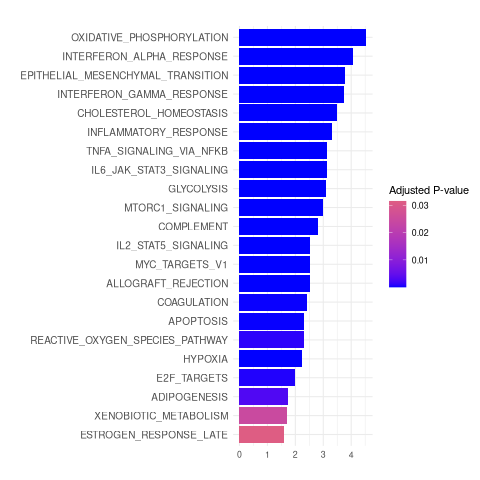

In [37]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/Cupr_demyel_DAM_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [38]:
%%R
unique(fgsea_MOL4_significant$pathway)

 [1] "HALLMARK_ADIPOGENESIS"                     
 [2] "HALLMARK_ALLOGRAFT_REJECTION"              
 [3] "HALLMARK_APOPTOSIS"                        
 [4] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [5] "HALLMARK_COAGULATION"                      
 [6] "HALLMARK_COMPLEMENT"                       
 [7] "HALLMARK_E2F_TARGETS"                      
 [8] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
 [9] "HALLMARK_ESTROGEN_RESPONSE_LATE"           
[10] "HALLMARK_G2M_CHECKPOINT"                   
[11] "HALLMARK_GLYCOLYSIS"                       
[12] "HALLMARK_HYPOXIA"                          
[13] "HALLMARK_IL2_STAT5_SIGNALING"              
[14] "HALLMARK_IL6_JAK_STAT3_SIGNALING"          
[15] "HALLMARK_INFLAMMATORY_RESPONSE"            
[16] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[17] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
[18] "HALLMARK_MTORC1_SIGNALING"                 
[19] "HALLMARK_MYC_TARGETS_V1"                   
[20] "HALLMARK_OXIDATIVE_PHOSPHORYLATION"        


In [39]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_ANGIOGENESIS"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [40]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Lpl"    "Lgals3" "Anxa5"  "Fabp5"  "Cxcl16" "Plaur"  "Nfil3"  "Alcam" 
 [9] "Ctnnb1" "Cd9"    "Ethe1"  "Gusb"   "Atf5"   "Scd2"   "Plscr1"


In [41]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Il3ra"   "Tlr2"    "Csf1"    "Il1b"    "Csf2ra"  "Pim1"    "Cxcl1"  
 [8] "Cxcl2"   "Stat1"   "Cd44"    "Il2rg"   "Cxcl10"  "Cd9"     "Cd14"   
[15] "Fas"     "Cd36"    "Bak1"    "Pf4"     "Itga4"   "Crlf2"   "Ifnar1" 
[22] "Csf2rb2"


In [42]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Prdx4"   "Glrx"    "Prdx1"   "Gpx3"    "Txn1"    "Srxn1"   "Sod2"   
 [8] "Lsp1"    "Atox1"   "Lamtor5" "Prdx6"   "Prdx2"  


In [43]:
%%R

class(fgsea_MOL4_significant)

[1] "data.table" "data.frame"


In [44]:
%%R

fgsea_MOL4_significant <- as.data.frame(fgsea_MOL4_significant)

In [45]:
%%R
library(data.table)
fwrite(fgsea_MOL4_significant, file = "./files/filtered_fgseaResSignificant_Cupr_demyel_DAMs.csv")

# Cupr_remyel_MOL

In [9]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/Cupr_remyel_MG_DAM_voom_wqw.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

     gene     logFC   AveExpr        t      P.Value    adj.P.Val         B
1    Spp1 11.853414  5.822141 22.18537 2.349556e-09 2.185087e-05  9.662733
2  Lgals3  8.535586  6.181333 19.85277 6.459612e-09 3.003719e-05  9.871127
3     Lpl  6.462351  6.565490 18.90984 1.004574e-08 3.114180e-05 10.177300
4    Apoe  6.775695 12.793822 17.34368 2.195917e-08 5.105507e-05  9.996144
5    Igf1  9.201708  4.776384 16.56238 3.327074e-08 5.392055e-05  8.263733
6 Bcl2a1d  4.606289  6.675289 16.09655 4.300290e-08 5.392055e-05  9.222453


In [10]:
%%R

dim(df)

[1] 9300    7


In [11]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Spp1"    "Lgals3"  "Lpl"     "Apoe"    "Igf1"    "Bcl2a1d"


In [12]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [13]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [14]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


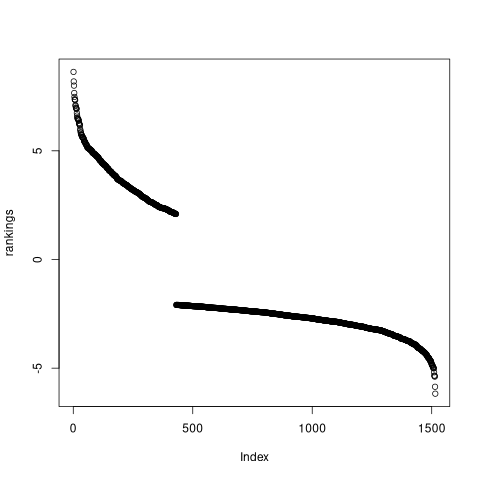

In [15]:
%%R

plot(rankings)

In [16]:
%%R

max(rankings)

[1] 8.629014


In [17]:
%%R

min(rankings)

[1] -6.173957


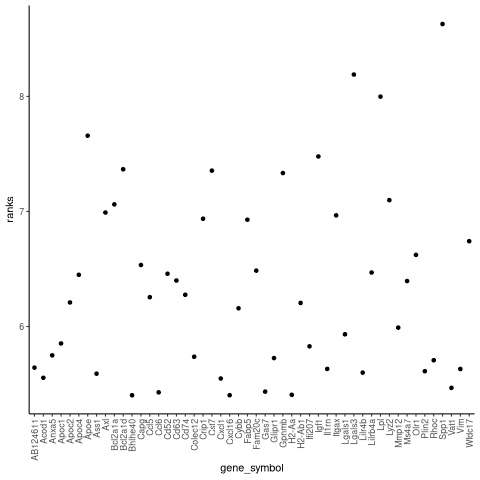

In [18]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [19]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [20]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 9.958138e-04 2.144830e-03
 2:               HALLMARK_ALLOGRAFT_REJECTION 1.510197e-04 4.698390e-04
 3:                         HALLMARK_APOPTOSIS 3.279861e-03 6.122407e-03
 4:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 1.103952e-05 5.151776e-05
 5:                       HALLMARK_COAGULATION 2.391044e-02 4.184327e-02
 6:                        HALLMARK_COMPLEMENT 4.484264e-08 6.277970e-07
 7: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 1.640190e-07 1.530844e-06
 8:           HALLMARK_ESTROGEN_RESPONSE_EARLY 2.423581e-01 3.231441e-01
 9:            HALLMARK_ESTROGEN_RESPONSE_LATE 2.371324e-01 3.231441e-01
10:             HALLMARK_FATTY_ACID_METABOLISM 9.433272e-01 9.682540e-01
11:                    HALLMARK_G2M_CHECKPOINT 6.996466e-01 7.819085e-01
12:                        HALLMARK_GLYCOLYSIS 2.51

In [21]:
%%R

dim(fgsea_res)

[1] 28  8


In [22]:
%%R

library(data.table)
fwrite(fgsea_res, file = "./files/fgsea_Cupr_remyel_DAMs_all.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [23]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL4_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL4_significant)

[1] 16  8


In [24]:
%%R

head(fgsea_MOL4_significant)

                            pathway         pval         padj   log2err
                             <char>        <num>        <num>     <num>
1:            HALLMARK_ADIPOGENESIS 9.958138e-04 2.144830e-03 0.4550599
2:     HALLMARK_ALLOGRAFT_REJECTION 1.510197e-04 4.698390e-04 0.5188481
3:               HALLMARK_APOPTOSIS 3.279861e-03 6.122407e-03 0.4317077
4: HALLMARK_CHOLESTEROL_HOMEOSTASIS 1.103952e-05 5.151776e-05 0.5933255
5:             HALLMARK_COAGULATION 2.391044e-02 4.184327e-02 0.3524879
6:              HALLMARK_COMPLEMENT 4.484264e-08 6.277970e-07 0.7195128
          ES      NES  size                             leadingEdge
       <num>    <num> <int>                                  <list>
1: 0.4805229 2.226916    21    Lpl,Apoe,Plin2,Gpx3,Abca1,Sowahc,...
2: 0.4104078 2.433690    43     Capg,Cd74,Ccl5,H2-Aa,Gpr65,Il1b,...
3: 0.3955793 2.104779    30   Lgals3,Cd44,Gpx3,Cd69,Ifitm3,Il1b,...
4: 0.6631518 2.670981    15 Lgals3,Lpl,Fabp5,Anxa5,Cxcl16,Nfil3,...
5: 0.3929198 1.7

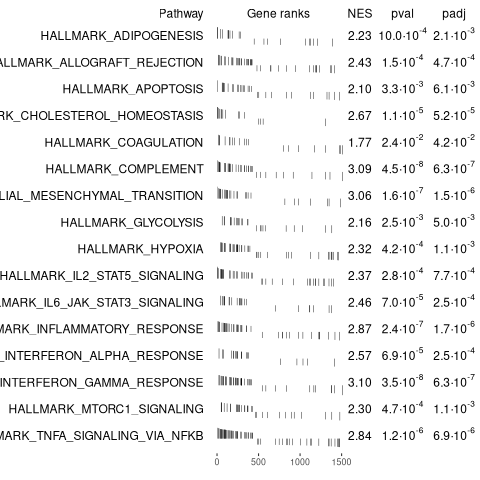

In [25]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL4_significant$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

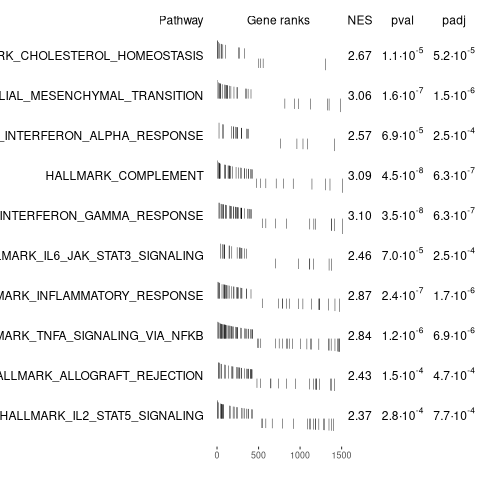

In [26]:
%%R

topUp <- fgsea_MOL4_significant %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)

topDown <- fgsea_MOL4_significant %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)

topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)

plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [27]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL4_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

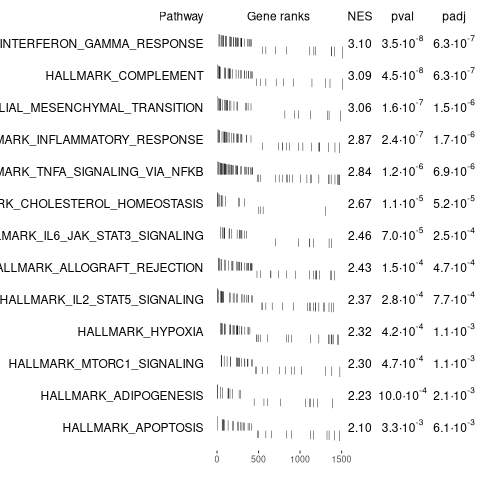

In [28]:
%%R

mainPathways <- fgsea_MOL4_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [29]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

In [30]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                           padj   NES  size
  <chr>                                            <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE         0.000000628  3.10    44
2 HALLMARK_COMPLEMENT                        0.000000628  3.09    39
3 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.00000153   3.06    29
4 HALLMARK_INFLAMMATORY_RESPONSE             0.00000169   2.87    42
5 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.00000687   2.84    62
6 HALLMARK_CHOLESTEROL_HOMEOSTASIS           0.0000515    2.67    15


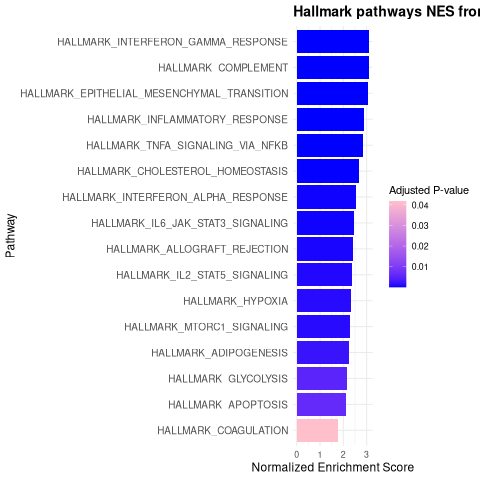

In [31]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "pink", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

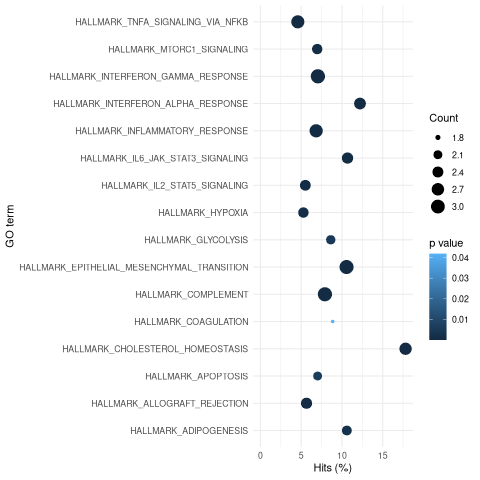

In [32]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [33]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                           padj   NES  size
  <chr>                                            <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE         0.000000628  3.10    44
2 HALLMARK_COMPLEMENT                        0.000000628  3.09    39
3 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.00000153   3.06    29
4 HALLMARK_INFLAMMATORY_RESPONSE             0.00000169   2.87    42
5 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.00000687   2.84    62
6 HALLMARK_CHOLESTEROL_HOMEOSTASIS           0.0000515    2.67    15


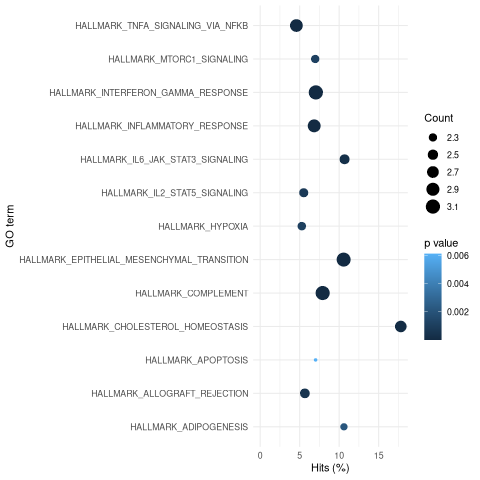

In [34]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Calculate hits percentage
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(filtered_fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()


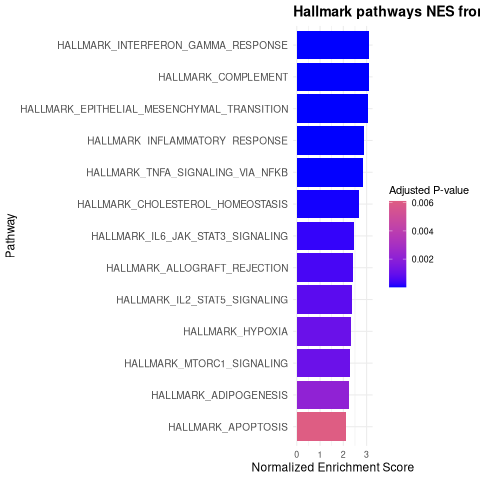

In [35]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [36]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                  padj   NES  size
  <chr>                                   <dbl> <dbl> <int>
1 INTERFERON_GAMMA_RESPONSE         0.000000628  3.10    44
2 COMPLEMENT                        0.000000628  3.09    39
3 EPITHELIAL_MESENCHYMAL_TRANSITION 0.00000153   3.06    29
4 INFLAMMATORY_RESPONSE             0.00000169   2.87    42
5 TNFA_SIGNALING_VIA_NFKB           0.00000687   2.84    62
6 CHOLESTEROL_HOMEOSTASIS           0.0000515    2.67    15


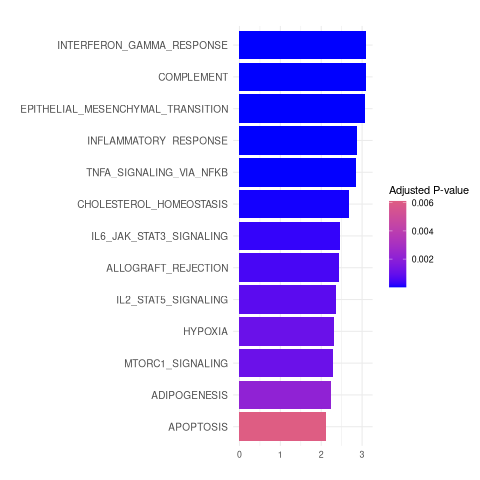

In [37]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/Cupr_remyel_DAM_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [38]:
%%R
unique(fgsea_MOL4_significant$pathway)

 [1] "HALLMARK_ADIPOGENESIS"                     
 [2] "HALLMARK_ALLOGRAFT_REJECTION"              
 [3] "HALLMARK_APOPTOSIS"                        
 [4] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [5] "HALLMARK_COAGULATION"                      
 [6] "HALLMARK_COMPLEMENT"                       
 [7] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
 [8] "HALLMARK_GLYCOLYSIS"                       
 [9] "HALLMARK_HYPOXIA"                          
[10] "HALLMARK_IL2_STAT5_SIGNALING"              
[11] "HALLMARK_IL6_JAK_STAT3_SIGNALING"          
[12] "HALLMARK_INFLAMMATORY_RESPONSE"            
[13] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[14] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
[15] "HALLMARK_MTORC1_SIGNALING"                 
[16] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"          


In [39]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Lgals3" "Lpl"    "Fabp5"  "Anxa5"  "Cxcl16" "Nfil3"  "Alcam"  "Plaur" 
 [9] "Ctnnb1" "Cd9"    "Atf5"  


In [40]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_IL2_STAT5_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Spp1"    "Cst7"    "Capg"    "Plin2"   "Bhlhe40" "Gpr65"   "Nfil3"  
 [8] "Cd44"    "Alcam"   "Il3ra"   "Ifitm3"  "Pim1"    "Phlda1"  "Anxa4"  
[15] "Rragd"   "Cd83"    "Ctsz"    "Cxcl10"  "Smpdl3a" "Fgl2"    "Csf1"   
[22] "Gadd45b" "Maff"   


In [41]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cxcl1"  "Cd44"   "Il3ra"  "Cxcl2"  "Il1b"   "Itga4"  "Pim1"   "Tlr2"  
 [9] "Csf2ra" "Cd9"    "Il2rg"  "Cd36"   "Cxcl10" "Cd14"   "Tnf"    "Csf1"  


In [42]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cd74"     "Lgals3bp" "Ifitm3"   "Ifitm2"   "Oas1a"    "Isg15"   
 [7] "Ifih1"    "Bst2"     "B2m"      "Ccrl2"    "Samd9l"   "Cxcl10"  
[13] "H2-Q7"    "Csf1"     "Usp18"    "Gbp2"    


In [43]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cd74"     "Ccl5"     "H2-Aa"    "H2-Eb1"   "Lgals3bp" "Cd69"    
 [7] "Ifitm3"   "Tnfaip2"  "Ptgs2"    "Cd274"    "Pim1"     "Slamf7"  
[13] "Vcam1"    "Ifitm2"   "Gch1"     "Isg15"    "Ifih1"    "Il18bp"  
[19] "Bst2"     "B2m"      "Cdkn1a"   "Hif1a"    "Sod2"     "Samd9l"  
[25] "Cxcl10"   "Mt2"      "H2-Q7"    "Fgl2"     "Usp18"    "H2-D1"   
[31] "Nlrc5"    "H2-M3"    "Jak2"    


In [44]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Bcl2a1a" "Olr1"    "Ccl5"    "Cxcl1"   "Bhlhe40" "Nfil3"   "Ptger4" 
 [8] "Cd44"    "Cd69"    "Cxcl2"   "Il1b"    "Tnfaip2" "Plaur"   "Ptgs2"  
[15] "Slc2a6"  "Abca1"   "Ehd1"    "Tnfsf9"  "Phlda1"  "Dram1"   "Tlr2"   
[22] "Tank"    "Gch1"    "Ifih1"   "Cd83"    "Sdc4"    "Ccrl2"   "Cdkn1a" 
[29] "Sod2"    "Cxcl10"  "Tnf"     "Id2"     "Csf1"    "Gadd45b" "Maff"   
[36] "Ccl4"    "Bcl3"    "Kynu"    "Tnfaip8"


In [45]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_KRAS_SIGNALING_UP"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [46]:
%%R

fgsea_MOL4_significant <- as.data.frame(fgsea_MOL4_significant)

In [47]:
%%R
library(data.table)
fwrite(fgsea_MOL4_significant, file = "./files/filtered_fgseaResSignificant_Cupr_remyel_DAMs.csv")

# Combined dot plot

In [63]:
%%R

# Load the data.table package
library(data.table)

# Read the files back into R
LPC_de_F <- fread("./files/filtered_fgsea_LPC_demyel_BAM_significant_NEW.csv")
LPC_de_E <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_DAMs.csv")
LPC_re_E <- fread("./files/filtered_fgseaResSignificant_LPC_remyel_DAMs.csv")
Cupr_de_G <- fread("./files/filtered_fgseaResSignificant_Cupr_demyel_DAMs.csv")
Cupr_re_E <- fread("./files/filtered_fgseaResSignificant_Cupr_remyel_DAMs.csv")

In [64]:
%%R

# Subset the data frames to include only pathway, padj, NES, and size
subset_columns <- c("pathway", "NES", "padj")

#OPC_de_subset <- OPC_de[, ..subset_columns]
LPC_de_F_subset <- LPC_de_F[, ..subset_columns]
LPC_de_E_subset <- LPC_de_E[, ..subset_columns]
LPC_re_E_subset <- LPC_re_E[, ..subset_columns]
Cupr_de_G_subset <- Cupr_de_G[, ..subset_columns]
Cupr_re_E_subset <- Cupr_re_E[, ..subset_columns]

In [65]:
%%R

# Combine the 'pathway' columns from all the data frames
all_pathways <- unique(c(LPC_de_F$pathway, LPC_de_E$pathway,
                        LPC_re_E$pathway, Cupr_de_G$pathway, Cupr_re_E$pathway))

# Verify the unique pathways
print(head(all_pathways))

# Check the total number of unique pathways
length(all_pathways)

[1] "ADIPOGENESIS"                      "APOPTOSIS"                        
[3] "CHOLESTEROL_HOMEOSTASIS"           "EPITHELIAL_MESENCHYMAL_TRANSITION"
[5] "FATTY_ACID_METABOLISM"             "GLYCOLYSIS"                       
[1] 43


In [66]:
%%R
# Function to ensure each data frame includes all pathways and fills missing ones with NaN
fill_missing_pathways <- function(df, all_pathways) {
  # Identify pathways that are missing in the current data frame
  missing_pathways <- setdiff(all_pathways, df$pathway)
  
  # Create a data frame with missing pathways, NES and padj set to NaN
  missing_data <- data.frame(pathway = missing_pathways, 
                             NES = rep(NaN, length(missing_pathways)), 
                             padj = rep(NaN, length(missing_pathways)))
  
  # Combine the original data frame with the missing pathways
  df <- rbind(df[, c("pathway", "NES", "padj")], missing_data)
  
  # Sort by pathway to maintain a consistent order
  df <- df[order(df$pathway), ]
  
  return(df)
}

# Combine the 'pathway' columns from all the data frames
all_pathways <- unique(c(LPC_de_F$pathway, LPC_de_E$pathway,
                        LPC_re_E$pathway, Cupr_de_G$pathway, Cupr_re_E$pathway))

# Apply the function to all data frames
#OPC_de_filtered <- fill_missing_pathways(OPC_de_subset, all_pathways)
LPC_de_F_filtered <- fill_missing_pathways(LPC_de_F_subset, all_pathways)
LPC_de_E_filtered <- fill_missing_pathways(LPC_de_E_subset, all_pathways)
LPC_re_E_filtered <- fill_missing_pathways(LPC_re_E_subset, all_pathways)
Cupr_de_G_filtered <- fill_missing_pathways(Cupr_de_G_subset, all_pathways)
Cupr_re_E_filtered <- fill_missing_pathways(Cupr_re_E_subset, all_pathways)

In [67]:
%%R

LPC_de_F_filtered$condition <- "LPC_de_BAMs"
LPC_de_E_filtered$condition <- "LPC_de_DAMs"
LPC_re_E_filtered$condition <- "LPC_re_DAMs"
Cupr_de_G_filtered$condition <- "Cupr_de_DAMs"
Cupr_re_E_filtered$condition <- "Cupr_re_DAMs"

# Combine all datasets into a single dataframe
combined_df <- rbind(LPC_de_F_filtered, LPC_de_E_filtered,
                    LPC_re_E_filtered, Cupr_de_G_filtered, Cupr_re_E_filtered)

# Verify the structure
head(combined_df)

                             pathway      NES         padj   condition
                              <char>    <num>        <num>      <char>
1:                      ADIPOGENESIS 2.172977 0.0001812693 LPC_de_BAMs
2:                         APOPTOSIS 1.606209 0.0345045135 LPC_de_BAMs
3:           CHOLESTEROL_HOMEOSTASIS 2.501787 0.0016983951 LPC_de_BAMs
4: EPITHELIAL_MESENCHYMAL_TRANSITION 2.039798 0.0045816562 LPC_de_BAMs
5:             FATTY_ACID_METABOLISM 1.719075 0.0345045135 LPC_de_BAMs
6:                        GLYCOLYSIS 2.391067 0.0001812693 LPC_de_BAMs


In [68]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
combined_df$pathway <- gsub("^HALLMARK_", "", combined_df$pathway)

# View the updated heatmap_df
head(combined_df)

                             pathway      NES         padj   condition
                              <char>    <num>        <num>      <char>
1:                      ADIPOGENESIS 2.172977 0.0001812693 LPC_de_BAMs
2:                         APOPTOSIS 1.606209 0.0345045135 LPC_de_BAMs
3:           CHOLESTEROL_HOMEOSTASIS 2.501787 0.0016983951 LPC_de_BAMs
4: EPITHELIAL_MESENCHYMAL_TRANSITION 2.039798 0.0045816562 LPC_de_BAMs
5:             FATTY_ACID_METABOLISM 1.719075 0.0345045135 LPC_de_BAMs
6:                        GLYCOLYSIS 2.391067 0.0001812693 LPC_de_BAMs


In [69]:
%%R

# Transform padj to -log10 for better visualization
combined_df$log_padj <- -log10(combined_df$padj)

In addition: Warning message:
Removed 121 rows containing missing values or values outside the scale range
(`geom_point()`). 


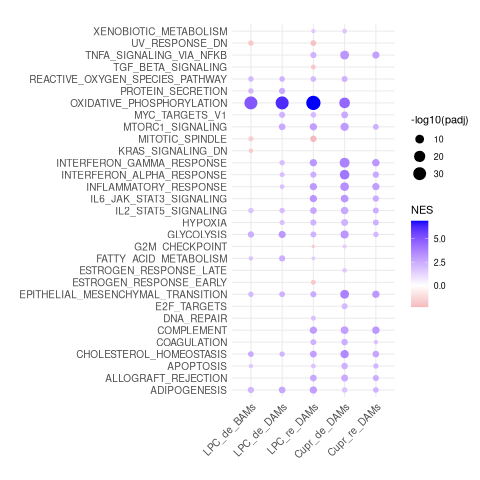

In [70]:
%%R

library(ggplot2)

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("LPC_de_BAMs", "LPC_de_DAMs", "LPC_re_DAMs",
                                           "Cupr_de_DAMs", "Cupr_re_DAMs"))

# Create the dotplot with switched axes and assign to heatmap_plot
heatmap_plot <- ggplot(combined_df, aes(y = pathway, x = condition, size = log_padj, color = NES)) +
  geom_point() +
  scale_color_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10), # Adjust pathway text size for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) + # Adjust condition text
  labs(x = "", y = "", 
       size = "-log10(padj)", color = "NES", 
       title = "")

# Show the plot
print(heatmap_plot)

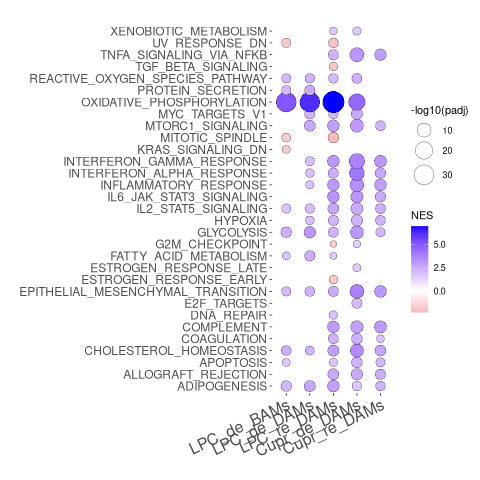

In [71]:
%%R

# Remove rows with missing or NaN values in `log_padj` or `NES`
filtered_df <- combined_df[!is.na(combined_df$log_padj) & !is.na(combined_df$NES), ]

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("LPC_de_BAMs", "LPC_de_DAMs", "LPC_re_DAMs",
                                           "Cupr_de_DAMs", "Cupr_re_DAMs"))

# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  theme_minimal() +
  theme(
    panel.grid = element_blank(), # Remove grid lines
    axis.text.y = element_text(size = 12), # Adjust pathway text size
    axis.text.x = element_text(angle = 25, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3) # Adjust x-axis ticks with `linewidth`
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

# Save the plot
#ggsave("./figures/GSEA/heatmap_pathway_NES_padj_ALL_only.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

In [72]:
%%R
print(unique(filtered_df$pathway))

 [1] "ADIPOGENESIS"                      "APOPTOSIS"                        
 [3] "CHOLESTEROL_HOMEOSTASIS"           "EPITHELIAL_MESENCHYMAL_TRANSITION"
 [5] "FATTY_ACID_METABOLISM"             "GLYCOLYSIS"                       
 [7] "IL2_STAT5_SIGNALING"               "KRAS_SIGNALING_DN"                
 [9] "MITOTIC_SPINDLE"                   "OXIDATIVE_PHOSPHORYLATION"        
[11] "PROTEIN_SECRETION"                 "REACTIVE_OXYGEN_SPECIES_PATHWAY"  
[13] "UV_RESPONSE_DN"                    "HYPOXIA"                          
[15] "INFLAMMATORY_RESPONSE"             "INTERFERON_ALPHA_RESPONSE"        
[17] "INTERFERON_GAMMA_RESPONSE"         "MTORC1_SIGNALING"                 
[19] "MYC_TARGETS_V1"                    "ALLOGRAFT_REJECTION"              
[21] "COAGULATION"                       "COMPLEMENT"                       
[23] "DNA_REPAIR"                        "ESTROGEN_RESPONSE_EARLY"          
[25] "G2M_CHECKPOINT"                    "IL6_JAK_STAT3_SIGNALING"          

In [79]:
%%R

# Define the desired order for the pathways
desired_pathway_order <- c("CHOLESTEROL_HOMEOSTASIS",
                            "GLYCOLYSIS",
                            "IL2_STAT5_SIGNALING",
                            "EPITHELIAL_MESENCHYMAL_TRANSITION",
                            "ADIPOGENESIS",
                            "OXIDATIVE_PHOSPHORYLATION",
                            "REACTIVE_OXYGEN_SPECIES_PATHWAY",
                            "INTERFERON_GAMMA_RESPONSE",
                            "INTERFERON_ALPHA_RESPONSE",
                            "INFLAMMATORY_RESPONSE",
                            "MTORC1_SIGNALING",
                            "HYPOXIA",
                           "APOPTOSIS",
                           "FATTY_ACID_METABOLISM",
                           "MYC_TARGETS_V1",
                            "IL6_JAK_STAT3_SIGNALING",
                            "TNFA_SIGNALING_VIA_NFKB",
                            "COMPLEMENT",
                            "COAGULATION",
                            "ALLOGRAFT_REJECTION",
                            "PROTEIN_SECRETION",
                            "UV_RESPONSE_DN",
                            "MITOTIC_SPINDLE",
                            "XENOBIOTIC_METABOLISM",
                            "G2M_CHECKPOINT",
                            "KRAS_SIGNALING_DN",
                            "DNA_REPAIR",
                            "ESTROGEN_RESPONSE_EARLY",
                            "TGF_BETA_SIGNALING",
                           "E2F_TARGETS",
                            "ESTROGEN_RESPONSE_LATE")  # Replace with actual pathway names

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = desired_pathway_order)

# Verify the order
print(levels(filtered_df$pathway))

 [1] "CHOLESTEROL_HOMEOSTASIS"           "GLYCOLYSIS"                       
 [3] "IL2_STAT5_SIGNALING"               "EPITHELIAL_MESENCHYMAL_TRANSITION"
 [5] "ADIPOGENESIS"                      "OXIDATIVE_PHOSPHORYLATION"        
 [7] "REACTIVE_OXYGEN_SPECIES_PATHWAY"   "INTERFERON_GAMMA_RESPONSE"        
 [9] "INTERFERON_ALPHA_RESPONSE"         "INFLAMMATORY_RESPONSE"            
[11] "MTORC1_SIGNALING"                  "HYPOXIA"                          
[13] "APOPTOSIS"                         "FATTY_ACID_METABOLISM"            
[15] "MYC_TARGETS_V1"                    "IL6_JAK_STAT3_SIGNALING"          
[17] "TNFA_SIGNALING_VIA_NFKB"           "COMPLEMENT"                       
[19] "COAGULATION"                       "ALLOGRAFT_REJECTION"              
[21] "PROTEIN_SECRETION"                 "UV_RESPONSE_DN"                   
[23] "MITOTIC_SPINDLE"                   "XENOBIOTIC_METABOLISM"            
[25] "G2M_CHECKPOINT"                    "KRAS_SIGNALING_DN"                

In [80]:
%%R
# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = reversed_pathway_order)

# Verify the reversed order
print(levels(filtered_df$pathway))

 [1] "ESTROGEN_RESPONSE_LATE"            "E2F_TARGETS"                      
 [3] "TGF_BETA_SIGNALING"                "ESTROGEN_RESPONSE_EARLY"          
 [5] "DNA_REPAIR"                        "KRAS_SIGNALING_DN"                
 [7] "G2M_CHECKPOINT"                    "XENOBIOTIC_METABOLISM"            
 [9] "MITOTIC_SPINDLE"                   "UV_RESPONSE_DN"                   
[11] "PROTEIN_SECRETION"                 "ALLOGRAFT_REJECTION"              
[13] "COAGULATION"                       "COMPLEMENT"                       
[15] "TNFA_SIGNALING_VIA_NFKB"           "IL6_JAK_STAT3_SIGNALING"          
[17] "MYC_TARGETS_V1"                    "FATTY_ACID_METABOLISM"            
[19] "APOPTOSIS"                         "HYPOXIA"                          
[21] "MTORC1_SIGNALING"                  "INFLAMMATORY_RESPONSE"            
[23] "INTERFERON_ALPHA_RESPONSE"         "INTERFERON_GAMMA_RESPONSE"        
[25] "REACTIVE_OXYGEN_SPECIES_PATHWAY"   "OXIDATIVE_PHOSPHORYLATION"        

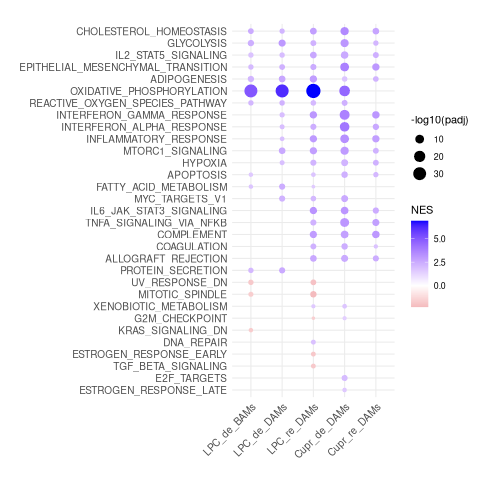

In [81]:
%%R

# Create the dotplot with switched axes and assign to heatmap_plot
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, color = NES)) +
  geom_point() +
  scale_color_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10), # Adjust pathway text size for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) + # Adjust condition text
  labs(x = "", y = "", 
       size = "-log10(padj)", color = "NES", 
       title = "")

# Show the plot
print(heatmap_plot)

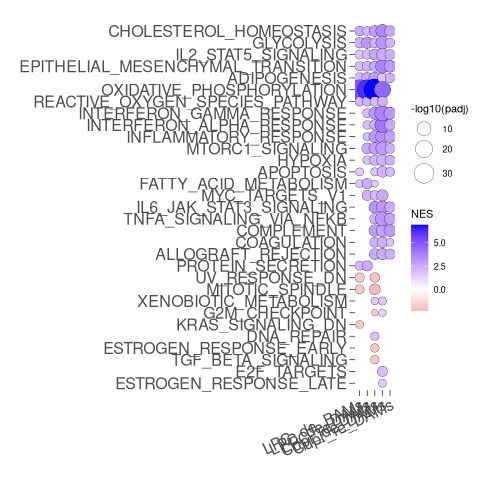

In [82]:
%%R

heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 25, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

print(heatmap_plot)

ggsave("./figures/GSEA/heatmap_pathway_NES_padj_Mg_ordered.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

 [1] "Estrogen Response (Late)"          "E2F Targets"                      
 [3] "TGF-β Signaling"                   "Estrogen Response (Early)"        
 [5] "DNA Repair"                        "KRAS Signaling (Down)"            
 [7] "G2M Checkpoint"                    "Xenobiotic Metabolism"            
 [9] "Mitotic Spindle"                   "UV Response (Down)"               
[11] "Protein Secretion"                 "Allograft Rejection"              
[13] "Coagulation"                       "Complement"                       
[15] "TNFα Signaling via NF-κB"          "IL-6/JAK/STAT3 Signaling"         
[17] "MYC Targets V1"                    "Fatty Acid Metabolism"            
[19] "Apoptosis"                         "Hypoxia"                          
[21] "mTORC1 Signaling"                  "Inflammatory Response"            
[23] "Interferon-α Response"             "Interferon-γ Response"            
[25] "Reactive Oxygen Species Pathway"   "Oxidative Phosphorylation"        

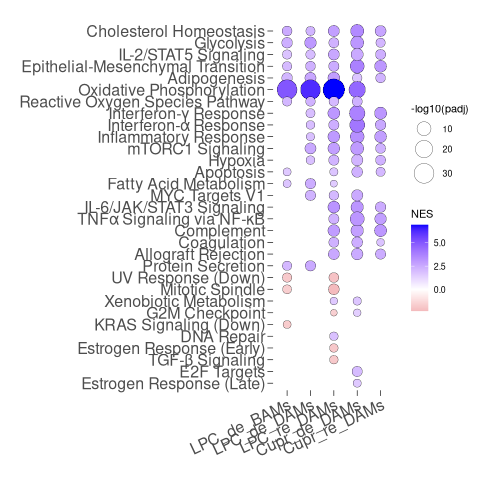

In [83]:
%%R

# Define formatted pathway names dictionary
pathway_name_format <- c(
    "CHOLESTEROL_HOMEOSTASIS" = "Cholesterol Homeostasis",
    "GLYCOLYSIS" = "Glycolysis",
    "IL2_STAT5_SIGNALING" = "IL-2/STAT5 Signaling",
    "EPITHELIAL_MESENCHYMAL_TRANSITION" = "Epithelial-Mesenchymal Transition",
    "ADIPOGENESIS" = "Adipogenesis",
    "OXIDATIVE_PHOSPHORYLATION" = "Oxidative Phosphorylation",
    "REACTIVE_OXYGEN_SPECIES_PATHWAY" = "Reactive Oxygen Species Pathway",
    "INTERFERON_GAMMA_RESPONSE" = "Interferon-γ Response",
    "INTERFERON_ALPHA_RESPONSE" = "Interferon-α Response",
    "INFLAMMATORY_RESPONSE" = "Inflammatory Response",
    "MTORC1_SIGNALING" = "mTORC1 Signaling",
    "HYPOXIA" = "Hypoxia",
    "APOPTOSIS" = "Apoptosis",
    "FATTY_ACID_METABOLISM" = "Fatty Acid Metabolism",
    "MYC_TARGETS_V1" = "MYC Targets V1",
    "IL6_JAK_STAT3_SIGNALING" = "IL-6/JAK/STAT3 Signaling",
    "TNFA_SIGNALING_VIA_NFKB" = "TNFα Signaling via NF-κB",
    "COMPLEMENT" = "Complement",
    "COAGULATION" = "Coagulation",
    "ALLOGRAFT_REJECTION" = "Allograft Rejection",
    "PROTEIN_SECRETION" = "Protein Secretion",
    "UV_RESPONSE_DN" = "UV Response (Down)",
    "MITOTIC_SPINDLE" = "Mitotic Spindle",
    "XENOBIOTIC_METABOLISM" = "Xenobiotic Metabolism",
    "G2M_CHECKPOINT" = "G2M Checkpoint",
    "KRAS_SIGNALING_DN" = "KRAS Signaling (Down)",
    "DNA_REPAIR" = "DNA Repair",
    "ESTROGEN_RESPONSE_EARLY" = "Estrogen Response (Early)",
    "TGF_BETA_SIGNALING" = "TGF-β Signaling",
    "E2F_TARGETS" = "E2F Targets",
    "ESTROGEN_RESPONSE_LATE" = "Estrogen Response (Late)"
)

# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Add formatted pathway names to the dataframe
filtered_df$formatted_pathway <- pathway_name_format[as.character(filtered_df$pathway)]

# Reorder the 'formatted_pathway' column based on reversed pathway order
filtered_df$formatted_pathway <- factor(filtered_df$formatted_pathway, levels = pathway_name_format[reversed_pathway_order])

# Verify the new order
print(levels(filtered_df$formatted_pathway))

# Create the heatmap plot
heatmap_plot <- ggplot(filtered_df, aes(y = formatted_pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 25, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Print the heatmap
print(heatmap_plot)

# Save the heatmap plot
ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only_ordered.png", plot = heatmap_plot, dpi = 300, width = 8.5, height = 8)